<a href="https://colab.research.google.com/github/TrevinWacker/Thinkful-Predicting-cancer-mortality/blob/main/Predicting_cancer_death_rate_(Regression_Capstone).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  **Predicting cancer death rates**
            
The data comes from ***Data.world*** user Noah Rippner, and is compiled from [census.gov](https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-detail.html), [cancer.gov](https://seer.cancer.gov/seerstat/variables/countyattribs/), and [clinicaltrials.gov](https://clinicaltrials.gov/ct2/results?term=&recr=&type=&rslt=&age_v=&gndr=&cond=cancer&intr=&titles=&outc=&spons=&lead=&id=&state1=&cntry1=NA%3AUS&state2=&cntry2=&state3=&cntry3=&locn=&rcv_s=01%2F01%2F2010&rcv_e=06%2F01%2F2016&lup_s=01%2F01%2F2010&lup_e=06%2F01%2F2016) from 2010.  In addition, I will be pulling [additional data](http://ghdx.healthdata.org/us-data) from 2010 to include additional potentially impacting features, such as  health spending, exercise prevelence, and drug use
.  
The target feature is  cancer death rate (number of deaths per 100,000 citizens) designated by county.  This is a regression problem with predominately numerical features, except for geographical location.  This model's intent is to inform county governments what impacts cancer deaths in their communities to implement new policies for prevention.  While this data is a bit dated, as of this project's completion, the framework and necessary analysis could apply to more recently compiled data.

In [ ]:
# Importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.tools.eval_measures import mse, rmse

from scipy import math
from scipy.stats import stats, f_oneway
from scipy.stats import bartlett, levene

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [ ]:
# Downloading main df
df = pd.read_csv("cancer_reg.csv", encoding="latin")

# Target feature is number of death annually per 100,000 residents.  All data from 2010. 
df.rename(columns={"TARGET_deathRate": "DeathRate"}, inplace=True)

# Dropping unneeded columns
df.drop(["binnedInc", "popEst2015"], axis=1, inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avgAnnCount              3047 non-null   float64
 1   avgDeathsPerYear         3047 non-null   int64  
 2   DeathRate                3047 non-null   float64
 3   incidenceRate            3047 non-null   float64
 4   medIncome                3047 non-null   int64  
 5   povertyPercent           3047 non-null   float64
 6   studyPerCap              3047 non-null   float64
 7   MedianAge                3047 non-null   float64
 8   MedianAgeMale            3047 non-null   float64
 9   MedianAgeFemale          3047 non-null   float64
 10  Geography                3047 non-null   object 
 11  AvgHouseholdSize         3047 non-null   float64
 12  PercentMarried           3047 non-null   float64
 13  PctNoHS18_24             3047 non-null   float64
 14  PctHS18_24              

avgAnnCount  avgDeathsPerYear  ...  PctMarriedHouseholds  BirthRate
0       1397.0               469  ...             52.856076   6.118831
1        173.0                70  ...             45.372500   4.333096
2        102.0                50  ...             54.444868   3.729488
3        427.0               202  ...             51.021514   4.603841
4         57.0                26  ...             54.027460   6.796657

[5 rows x 32 columns]

# Adding in additional heath-impacting factors

**Health spending** may impact the cancer mortality rate, as more investment in appropriate treatments could prevent additional deaths and more personalized care.  The data I've found is the sum total of ALL local spending within a state, so it is not specific to the county but rather to the state the county presides in.  This likely will lead to it not being as strong an explanatory factor as it would be if it was by individual county.

In [ ]:
# Gather data from 2010 census info
states_a2m = pd.read_excel("/content/10slsstab1a.xls", header=8)
states_m2w = pd.read_excel("/content/10slsstab1b.xls", header=8)

# Making the features already named for states have values equal to their LOCAL spending
for i in range(1,127,5):
  states_a2m.iloc[:,i] = states_a2m.iloc[:,i+3]
  states_m2w.iloc[:,i] = states_m2w.iloc[:,i+3]

# Eliminating columns that don't include desired health info
for i in range(2,131):
  try:
    states_a2m.drop(labels="Unnamed: {}".format(i), axis=1, inplace=True)
    states_m2w.drop(labels="Unnamed: {}".format(i), axis=1, inplace=True)    
  except KeyError:
    pass

# Drop overall US spending and description columns
states_a2m.drop(["United States Total", "Description"], axis=1, inplace=True)
states_m2w.drop("Description", axis=1, inplace=True)

# Put all states together in one dataset
general_health = states_a2m.join(states_m2w, how="outer")
general_health

Alabama      Alaska     Arizona  ... West Virginia   Wisconsin     Wyoming
0         Local       Local       Local  ...         Local       Local       Local
1    government  government  government  ...    government  government  government
2       amount1     amount1     amount1  ...       amount1     amount1     amount1
3             4           4           4  ...             4           4           4
4      21193608     4898525    29171252  ...       5401219    28007001     4776911
..          ...         ...         ...  ...           ...         ...         ...
183         NaN         NaN         NaN  ...           NaN         NaN         NaN
184         NaN         NaN         NaN  ...           NaN         NaN         NaN
185         NaN         NaN         NaN  ...           NaN         NaN         NaN
186         NaN         NaN         NaN  ...           NaN         NaN         NaN
187         NaN         NaN         NaN  ...           NaN         NaN         NaN

[188 rows x 51 columns]

After referencing with the excel file, the row on the dataframe that corresponds with expenditure on hospitals and health are `[100]` and `[102]` respectively, so those will be the values I'll extract to add onto the main dataframe

In [ ]:
# Making dataframe to merge onto main df
spending_df = pd.DataFrame()

# Getting in state names
spending_df["State"] = general_health.columns

# Getting total health spending
a_list = []
for i in range(0,51):
  a_list.append(general_health.loc[102][i])

spending_df["total health spending (Local Sum)"] = a_list

# Display spending_df
spending_df

State  total health spending (Local Sum)
0                Alabama                             359235
1                 Alaska                             112771
2                Arizona                             249196
3               Arkansas                              44206
4             California                           10744425
5               Colorado                             334978
6            Connecticut                             124894
7               Delaware                              31568
8   District of Columbia                             468943
9                Florida                            1128367
10               Georgia                            1009928
11                Hawaii                              57417
12                 Idaho                              62928
13              Illinois                             864423
14               Indiana                             264064
15                  Iowa                             400938
16                Kansas                             278647
17              Kentucky                             420805
18             Louisiana                             215492
19                 Maine                              29991
20              Maryland                             490085
21         Massachusetts                             124792
22              Michigan                            3135044
23             Minnesota                             694935
24           Mississippi                             104481
25              Missouri                             314386
26               Montana                             113567
27              Nebraska                              74446
28                Nevada                             137450
29         New Hampshire                              33595
30            New Jersey                             427110
31            New Mexico                              83735
32              New York                            3908737
33        North Carolina                            1607973
34          North Dakota                              23450
35                  Ohio                            2681926
36              Oklahoma                             144949
37                Oregon                             699476
38          Pennsylvania                            3068898
39          Rhode Island                              13124
40        South Carolina                             158452
41          South Dakota                              28923
42             Tennessee                             379344
43                 Texas                            2006173
44                  Utah                             211335
45               Vermont                              10462
46              Virginia                             954028
47            Washington                            1111360
48         West Virginia                              62334
49             Wisconsin                            1325846
50               Wyoming                              78353

In [ ]:
# Join onto main dataframe

# Make column to merge on to
for i in range(0,len(df)):
  county = df.loc[i,"Geography"]
  comma_loc = county.find(",")
  df.loc[i,"State"] = df.loc[i,"Geography"][comma_loc+2:]

df = df.join(spending_df.set_index("State"), on="State", how="outer")
df.head()
print(df.shape)
#These values are the total of ALL local muniscipalities, not specific to each county, so it's not a perfect representation of specific health spending in county
#but it at least gives an idea of what the area is spending.

(3047, 34)


I'll also add in factors regarding **the prevelance of obesity and physical activity** in individual counties.  The data is gathered from the [Institute of Health Metrics and Evalutation](http://ghdx.healthdata.org/record/ihme-data/united-states-physical-activity-and-obesity-prevalence-county-2001-2011)

Prevelancy here means, for obesity, the percent of the population that is medically classified as obese. However, for physical activity, it is the percent of those self reporting living appropriately active lifestyles.

In [ ]:
# Load in data
health_df = pd.read_csv("IHME_USA_OBESITY_PHYSICAL_ACTIVITY_2001_2011.csv", usecols=["State", "County", "Sex", "Outcome", "Prevalence 2010 (%)"])

# Create combined County and State feature
for i in range(0,len(health_df)):
  county = health_df.loc[i,"County"]
  comma_loc = county.find(",")
  health_df.loc[i,"Geography"] = health_df.loc[i,"County"][:comma_loc] + " County, " + health_df.loc[i,"State"]

# Create pivot table for merging to main DataFrame
obesity_pivot = pd.pivot_table(health_df, index="Geography", columns=["Outcome","Sex"], values="Prevalence 2010 (%)")
obesity_pivot

# Join to main DataFrame
df = df.join(obesity_pivot, on="Geography", how="inner")
df.rename(columns={("Any PA", "Female"):"PhysicalActivityFemale", ('Any PA', 'Male'):"PhysicalActivityMale", 
          ("Obesity", "Female"):"ObesityFemale", ("Obesity", "Male"):"ObesityMale"}, inplace=True)

df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


avgAnnCount  avgDeathsPerYear  ...  ObesityFemale  ObesityMale
0       1397.0               469  ...          35.80        34.25
1        173.0                70  ...          34.17        31.44
2        102.0                50  ...          34.90        36.61
3        427.0               202  ...          40.22        40.55
4         57.0                26  ...          37.06        36.27

[5 rows x 38 columns]

Alcohol use could also impact death rates for a myriad of reasons, including being a factor of an unhealthy lifestyle.  Here, we're looking specifically at heavy alcohol use as a potential factor (defined as ~15+/week for men and ~8+/week for women) to find more variation between counties over just alcohol use in general.  Data also gathered from [IHME](http://ghdx.healthdata.org/record/ihme-data/united-states-alcohol-use-prevalence-county-2002-2012)

In [ ]:
# Load in data
drinking_df = pd.read_excel("/content/IHME_USA_COUNTY_ALCOHOL_USE_PREVALENCE_2002_2012_NATIONAL_Y2015M04D23.XLSX", 
                        sheet_name="Heavy", 
                        usecols=["State", "Location", "2010 Females", "2010 Males"])

# Create combined County and State feature
drinking_df["Geography"] = drinking_df["Location"] + ", " + drinking_df["State"]
drinking_df.drop(["State", "Location"], axis=1, inplace=True)

# Rename columns before merging
drinking_df.rename(columns={"2010 Females":"HeavyAlcoholUseFemale", "2010 Males":"HeavyAlcoholUseMale"}, inplace=True)

# Merging onto main DataFrame
df = df.merge(drinking_df, on="Geography", how="inner")

df.head()

avgAnnCount  avgDeathsPerYear  ...  HeavyAlcoholUseFemale  HeavyAlcoholUseMale
0       1397.0               469  ...                    7.9                  9.1
1        173.0                70  ...                    9.9                 11.6
2        102.0                50  ...                    8.1                 11.2
3        427.0               202  ...                    6.3                  9.9
4         57.0                26  ...                   11.0                 13.5

[5 rows x 40 columns]

In [ ]:
#Checking dtypes transfer
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2910 entries, 0 to 2909
Data columns (total 40 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   avgAnnCount                        2910 non-null   float64
 1   avgDeathsPerYear                   2910 non-null   int64  
 2   DeathRate                          2910 non-null   float64
 3   incidenceRate                      2910 non-null   float64
 4   medIncome                          2910 non-null   int64  
 5   povertyPercent                     2910 non-null   float64
 6   studyPerCap                        2910 non-null   float64
 7   MedianAge                          2910 non-null   float64
 8   MedianAgeMale                      2910 non-null   float64
 9   MedianAgeFemale                    2910 non-null   float64
 10  Geography                          2910 non-null   object 
 11  AvgHouseholdSize                   2910 non-null   float

# Null values

In [ ]:
# First seeing the features that have null values to explore
df.isnull().sum()

avgAnnCount                             0
avgDeathsPerYear                        0
DeathRate                               0
incidenceRate                           0
medIncome                               0
povertyPercent                          0
studyPerCap                             0
MedianAge                               0
MedianAgeMale                           0
MedianAgeFemale                         0
Geography                               0
AvgHouseholdSize                        0
PercentMarried                          0
PctNoHS18_24                            0
PctHS18_24                              0
PctSomeCol18_24                      2181
PctBachDeg18_24                         0
PctHS25_Over                            0
PctBachDeg25_Over                       0
PctEmployed16_Over                    143
PctUnemployed16_Over                    0
PctPrivateCoverage                      0
PctPrivateCoverageAlone               592
PctEmpPrivCoverage                

PctSomeCol18_24, PctEmployed16_Over, and PctPrivateCoverageAlone are the only features with null values.  I'll examine each individually.

In [ ]:
# Let's start with PctSomeCol18_24
df.head()

avgAnnCount  avgDeathsPerYear  ...  HeavyAlcoholUseFemale  HeavyAlcoholUseMale
0       1397.0               469  ...                    7.9                  9.1
1        173.0                70  ...                    9.9                 11.6
2        102.0                50  ...                    8.1                 11.2
3        427.0               202  ...                    6.3                  9.9
4         57.0                26  ...                   11.0                 13.5

[5 rows x 40 columns]

In [ ]:
# These rows all contain other values for level of education so they can maybe fill in.
# Verifying if all rows add up to 100% if non-null
non_null = df[df["PctSomeCol18_24"].notnull()]
(non_null["PctNoHS18_24"] + non_null["PctHS18_24"] + non_null["PctSomeCol18_24"] + non_null["PctBachDeg18_24"] == 100).head(20)

0      True
1      True
3      True
4     False
7     False
11     True
14     True
16    False
17     True
23     True
28     True
30    False
32    False
39     True
40     True
47    False
50     True
51    False
55     True
56    False
dtype: bool

In [ ]:
# Not always true, so looking at rows that are false
false = non_null[non_null["PctNoHS18_24"] + non_null["PctHS18_24"] + non_null["PctSomeCol18_24"] + non_null["PctBachDeg18_24"] != 100]
false.head()

avgAnnCount  avgDeathsPerYear  ...  HeavyAlcoholUseFemale  HeavyAlcoholUseMale
4          57.0                26  ...                   11.0                 13.5
7         146.0                71  ...                    8.0                 13.3
16       1390.0               483  ...                    8.0                  9.2
30        194.0                70  ...                    8.2                  8.9
32        230.0                86  ...                    4.6                  7.5

[5 rows x 40 columns]

In [ ]:
# It looks like all of these rows add up to 99.9% or 100.1%.  Double checking below

(false["PctNoHS18_24"] + false["PctHS18_24"] + false["PctSomeCol18_24"] + false["PctBachDeg18_24"]).between(99.9,100.10001)

4        True
7        True
16       True
30       True
32       True
        ...  
2885     True
2887     True
2897    False
2905     True
2906     True
Length: 337, dtype: bool

In [ ]:
# This looks to be true; this indicates all these values are likely meant to be about 100% and rounding likely led to some having an incorrect sum
# Since this is the case, I will have PctSomeCol18_24 be the difference between 100 and the sum of other 18-24 educational values.  Error will be between +- 0.1%

df["PctSomeCol18_24"] = 100 - df["PctNoHS18_24"] - df["PctHS18_24"] - df["PctBachDeg18_24"]

PctPrivateCoverageAone

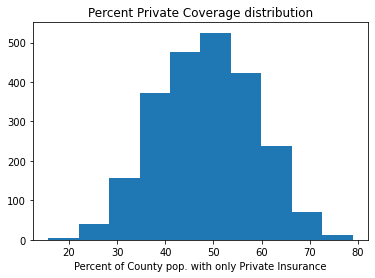


Correlation between cancer death rate and holding private insurance exclusively: -0.35545614750426485


In [ ]:
# PctPrivateCoverageAlone	has some null values, and there's no way of knowing what that value may be otherwise
# Will see how informative it is

plt.hist(df["PctPrivateCoverageAlone"])
plt.title("Percent Private Coverage distribution")
plt.xlabel("Percent of County pop. with only Private Insurance")
plt.show()

print()
print("Correlation between cancer death rate and holding private insurance exclusively: {}".format(df["DeathRate"].corr(df["PctPrivateCoverageAlone"])))

In [ ]:
# It seems to be correlated and have a wide distribution.  It may be collinear with other features, in which case we wouldn't include it in a model anyway
# Seeing if there is high correlation between PctPrivateCoverage and medIncome

print(df["PctPrivateCoverageAlone"].corr(df["PctPrivateCoverage"]))
df["PctPrivateCoverageAlone"].corr(df["medIncome"])

0.93236795958578


0.7991167047866237

In [ ]:
# Highly correlated with PctPrivateCoverage (greater than 0.8) so we'll drop the solo column
df.drop("PctPrivateCoverageAlone", axis=1, inplace=True)

PctEmployed16_Over

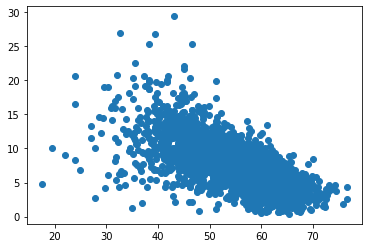

In [ ]:
# Checking PctEmployed16_Over corr. with PctUnemployed16_Over
df['PctEmployed16_Over'].corr(df["PctUnemployed16_Over"])
plt.scatter(df["PctEmployed16_Over"], df["PctUnemployed16_Over"])

In [ ]:
#There's an obvious correlation so it can be dropped
df["PctEmployed16_Over"].fillna(54.152, inplace=True)

# Determining division for Geography (feature engineering)

Since every county is provided, one-hot encoding or labeling data by individual line seems too redundant and nuanced.  To better utilize geography data, I will be designate each county by their geographic region, as defined by [the Department of Health & Human Services](https://www.hhs.gov/about/agencies/iea/regional-offices/index.html).  

This division leads to quite a bit of disproportion amongst groups, seeing as some of these regions would also include territories and independent cities, which aren't looked at in this project.  Finding the most ideal division of regions would definitely be something I'd want to explore after the completion of this project.

In [ ]:
# Division by geographic region
Region_1 = ('Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont')
Region_2 = ('New Jersey', 'New York')
Region_3 = ('Delaware', 'District of Columbia', 'Maryland', 'Pennsylvania', 'Virginia', 'West Virginia')
Region_4 = ('Alabama', 'Florida', 'Georgia', 'Kentucky', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee') # Highest values reached with DeathRate
Region_5 = ('Illinois', 'Indiana', 'Michigan', 'Minnesota', 'Ohio', 'Wisconsin')
Region_6 = ('Arkansas', 'Louisiana', 'New Mexico', 'Oklahoma', 'Texas')
Region_7 = ('Iowa', 'Kansas', 'Missouri', 'Nebraska')
Region_8 = ('Colorado', 'Montana', 'North Dakota', 'South Dakota', 'Utah', 'Wyoming')
Region_9 = ('Arizona', 'California', 'Hawaii', 'Nevada')
Region_10 = ('Alaska', 'Idaho', 'Oregon', 'Washington')

In [ ]:
#Assigning each line a region
for i in range(0,len(df)):
  if df.loc[i, "State"] in Region_1:
    df.loc[i, "Region"] = 1
  elif df.loc[i, "State"] in Region_2:
    df.loc[i, "Region"] = 2
  elif df.loc[i, "State"] in Region_3:
    df.loc[i, "Region"] = 3
  elif df.loc[i, "State"] in Region_4:
    df.loc[i, "Region"] = 4
  elif df.loc[i, "State"] in Region_5:
    df.loc[i, "Region"] = 5
  elif df.loc[i, "State"] in Region_6:
    df.loc[i, "Region"] = 6
  elif df.loc[i, "State"] in Region_7:
    df.loc[i, "Region"] = 7
  elif df.loc[i, "State"] in Region_8:
    df.loc[i, "Region"] = 8
  elif df.loc[i, "State"] in Region_9:
    df.loc[i, "Region"] = 9
  elif df.loc[i, "State"] in Region_10:
    df.loc[i, "Region"] = 10

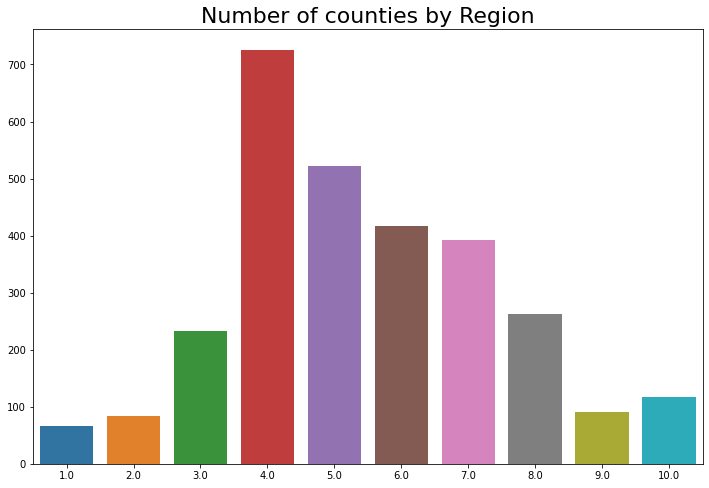

In [ ]:
# Getting counts of each Region in the DataFrame
val, cnt = np.unique(df["Region"], return_counts=True)

# See how many counties lie in each region
plt.figure(figsize=(12,8))
sns.barplot(x=val, y=cnt).set_title("Number of counties by Region", fontdict={'fontsize': 22});

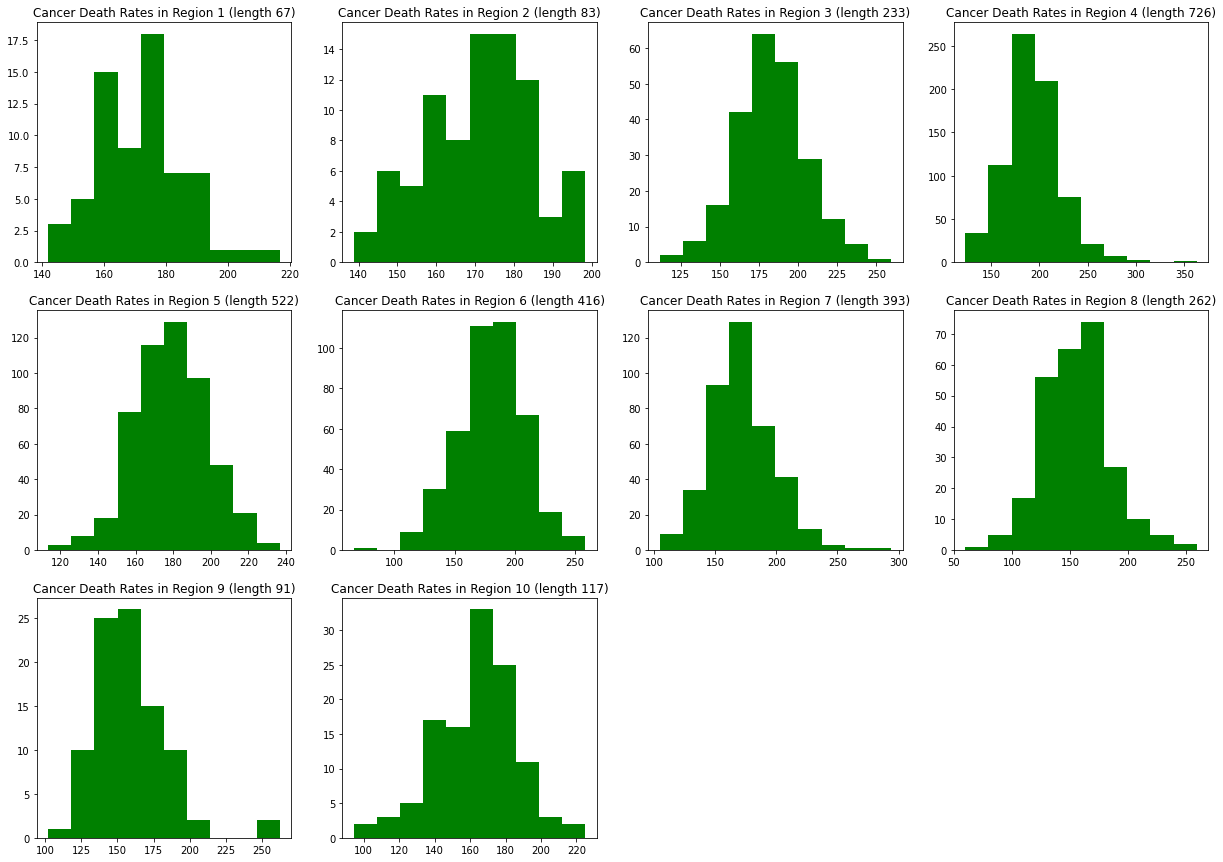

In [ ]:
# Looking at distribution of DeathRate by region
plt.figure(figsize=(21,15));
for i in range(1,11):
  plt.subplot(3,4,i)

  plot_df = df[df["Region"] == i]

  plt.hist(plot_df["DeathRate"], color='g')
  plt.title("Cancer Death Rates in Region {} (length {})".format(i,len(plot_df)))

All look to have a fairly normal distribution but with varying average deathrates and range of values.  A quick look indicates Region 4, which comprises most of the southern states, has the highest mean death rate and Region 8 & 9,which comprise Midwest states, have the lowest

# Data cleaning

Incorrectly labeled data

In [ ]:
# First going to look at numeric feature distributions to look for annomalies in values
numeric_columns = df.select_dtypes(include="number").columns.drop("Region", "DeathRate")

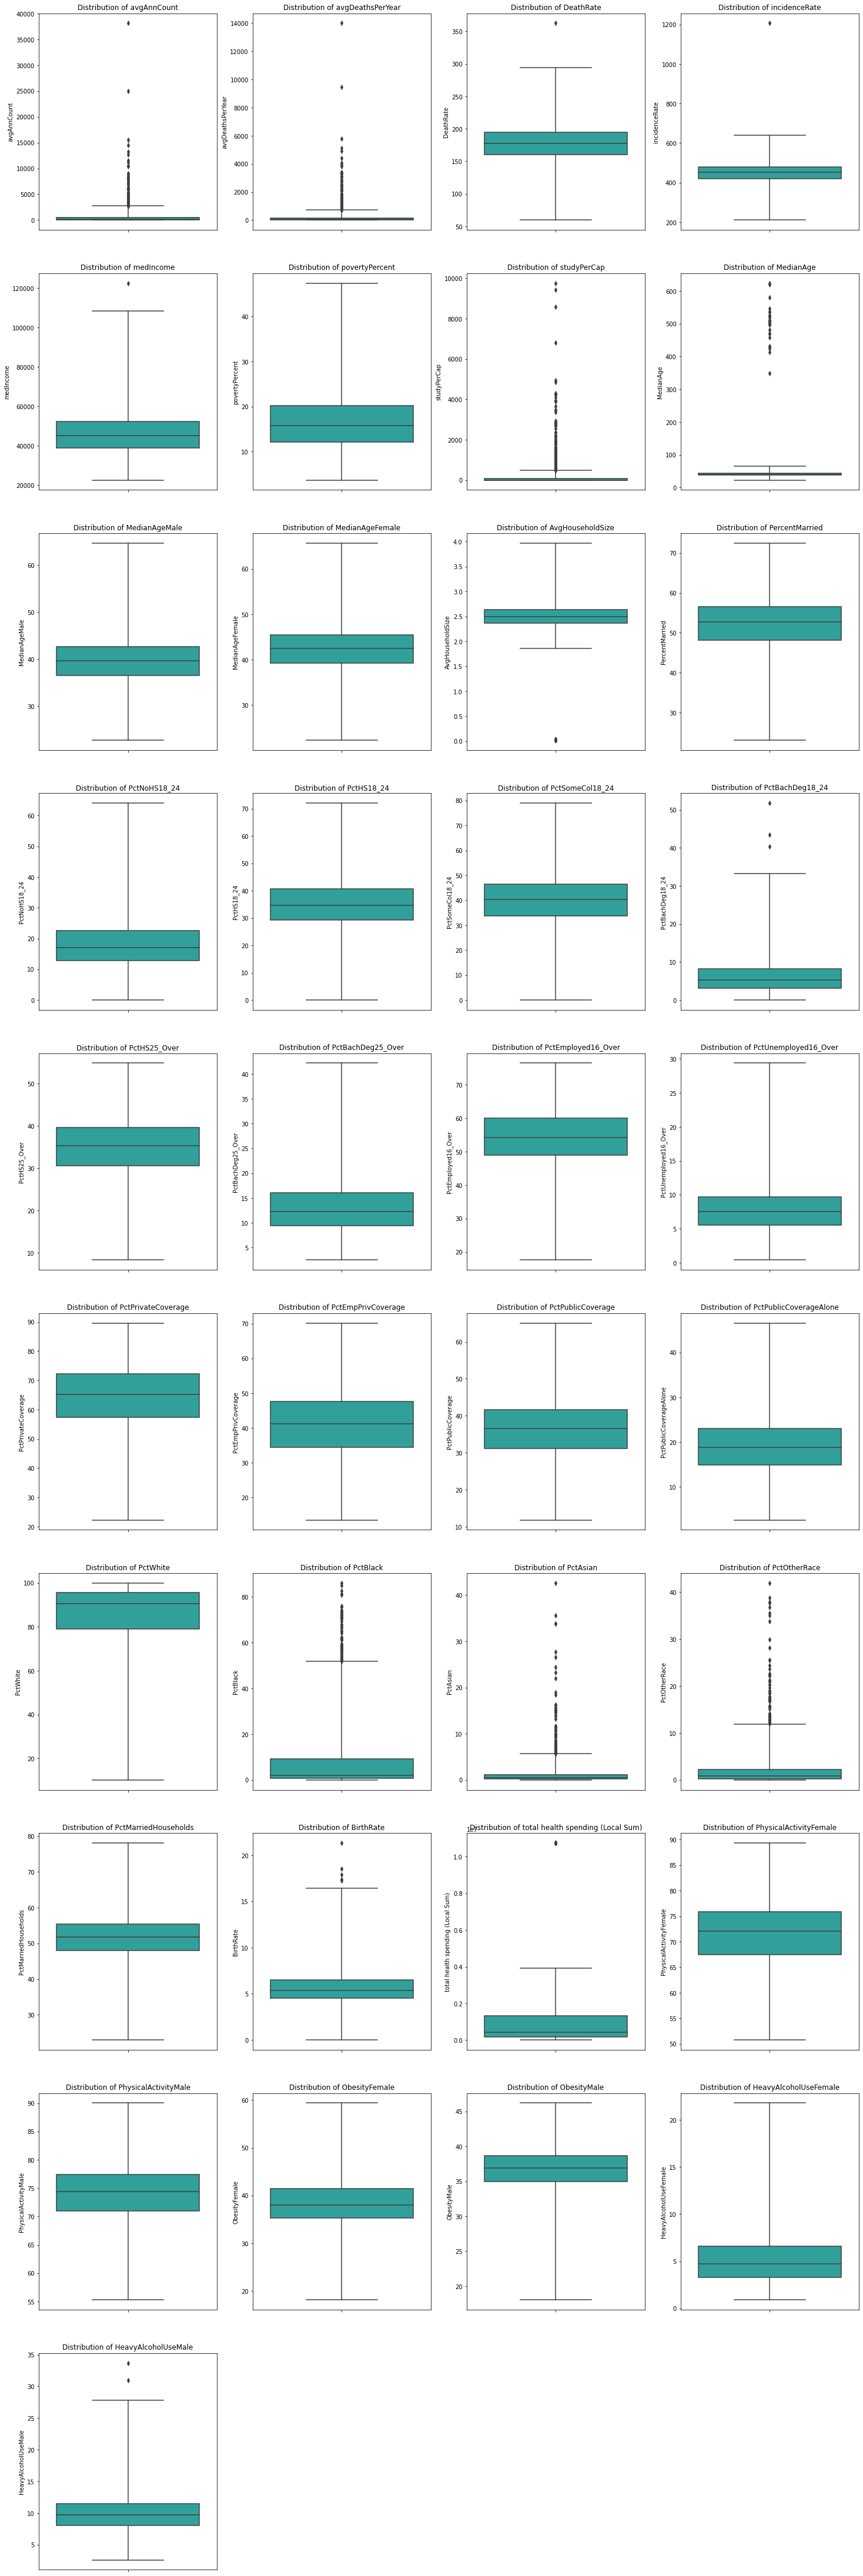

In [ ]:
#Plotting all numeric features
plt.figure(figsize=(25,80))
i = 1
for feature in numeric_columns:
  plt.subplot(10,4,i)
  sns.boxplot(y=df[feature], whis=5, color="lightseagreen",  orient="v")
  plt.title("Distribution of {}".format(feature))
  i+=1
plt.show();

In [ ]:
# MedianAge looks like it has some incorrect values; there are some values that far exceed the lifespan of a human

#Since we have MedAgeMale and MedAgeFemale, I'm going to drop the whole column
df.drop("MedianAge", axis=1, inplace=True)

In [ ]:
# AvgHouseholdSize also has some counties with less than 1 on average, but then none less than about 1.5

# Let's look closer at those with less than 1
df[df["AvgHouseholdSize"] < 1]

avgAnnCount  avgDeathsPerYear  ...  HeavyAlcoholUseMale  Region
40     499.000000               215  ...                  6.7     3.0
50      58.000000                22  ...                  7.6     3.0
160    707.000000               237  ...                 13.0     5.0
191     44.000000                14  ...                 11.8     7.0
256   1962.667684                20  ...                 12.8     9.0
257   1962.667684               154  ...                 13.8     9.0
329    465.000000               163  ...                 10.5     2.0
332    337.000000               121  ...                 11.3     2.0
348    154.000000                59  ...                 10.2     2.0
356   1470.000000               542  ...                 10.8     2.0
407    106.000000                44  ...                  9.1     3.0
439    181.000000                81  ...                  8.4     3.0
447     82.000000                39  ...                  7.3     3.0
615   1962.667684                26  ...                 10.1     5.0
655    164.000000                61  ...                  7.7     4.0
680    370.000000               138  ...                  8.4     4.0
734    344.000000               124  ...                  6.6     4.0
843    280.000000               121  ...                  7.6     4.0
907     48.000000                24  ...                  8.9     6.0
1050  1885.000000               713  ...                  6.5     4.0
1320    21.000000                 7  ...                  8.1     6.0
1367   177.000000                69  ...                 11.5     1.0
1386   522.000000               207  ...                 10.9     3.0
1431    97.000000                39  ...                  5.2     8.0
1563    67.000000                28  ...                  7.6     4.0
1584   106.000000                45  ...                  5.7     4.0
1678   181.000000                70  ...                 10.0     7.0
1715    43.000000                14  ...                 10.9     7.0
1727   118.000000                52  ...                 10.0     7.0
1781  1962.667684                11  ...                  8.7     7.0
1856    67.000000                32  ...                  9.5     4.0
1859   597.000000               234  ...                  9.5     4.0
1885  4320.000000              1623  ...                 10.2     4.0
1904    65.000000                28  ...                  8.3     4.0
1913   143.000000                57  ...                  6.6     4.0
1977   698.000000               300  ...                 10.9     4.0
1996   296.000000               139  ...                 10.1     4.0
2087   257.000000               114  ...                  8.0     6.0
2198   480.000000               225  ...                 11.6     5.0
2273   124.000000                41  ...                 10.2     3.0
2283    59.000000                21  ...                 14.3     3.0
2341   543.000000               213  ...                  8.0     4.0
2366   142.000000                59  ...                  6.2     5.0
2381   117.000000                50  ...                  8.6     5.0
2444   143.000000                60  ...                 13.3     7.0
2450   124.000000                56  ...                 16.6     7.0
2588    93.000000                44  ...                  7.8     4.0
2607    36.000000                17  ...                 12.6     4.0
2622    51.000000                20  ...                 10.1     4.0
2660    54.000000                24  ...                  9.3     4.0
2688   144.000000                62  ...                  7.1     4.0
2706    35.000000                15  ...                  6.4    10.0
2742   115.000000                50  ...                 13.4     5.0
2766   258.000000                93  ...                 13.0     5.0
2799   104.000000                42  ...                 12.8     5.0
2834  1551.000000               658  ...                 10.6     5.0
2838   399.00000

In [ ]:
# It seems there may have been some sort of miscalculation and those less than 1 are households that would average 1 person.
# I'm going to change all values less than 1 to 1

df.loc[df.AvgHouseholdSize < 1, "AvgHouseholdSize"] = 1

In [ ]:
# There seem to be quite a few features with outliers, but I'll see what insights elminiating collinearity can bring
# before addressing

Collinearity

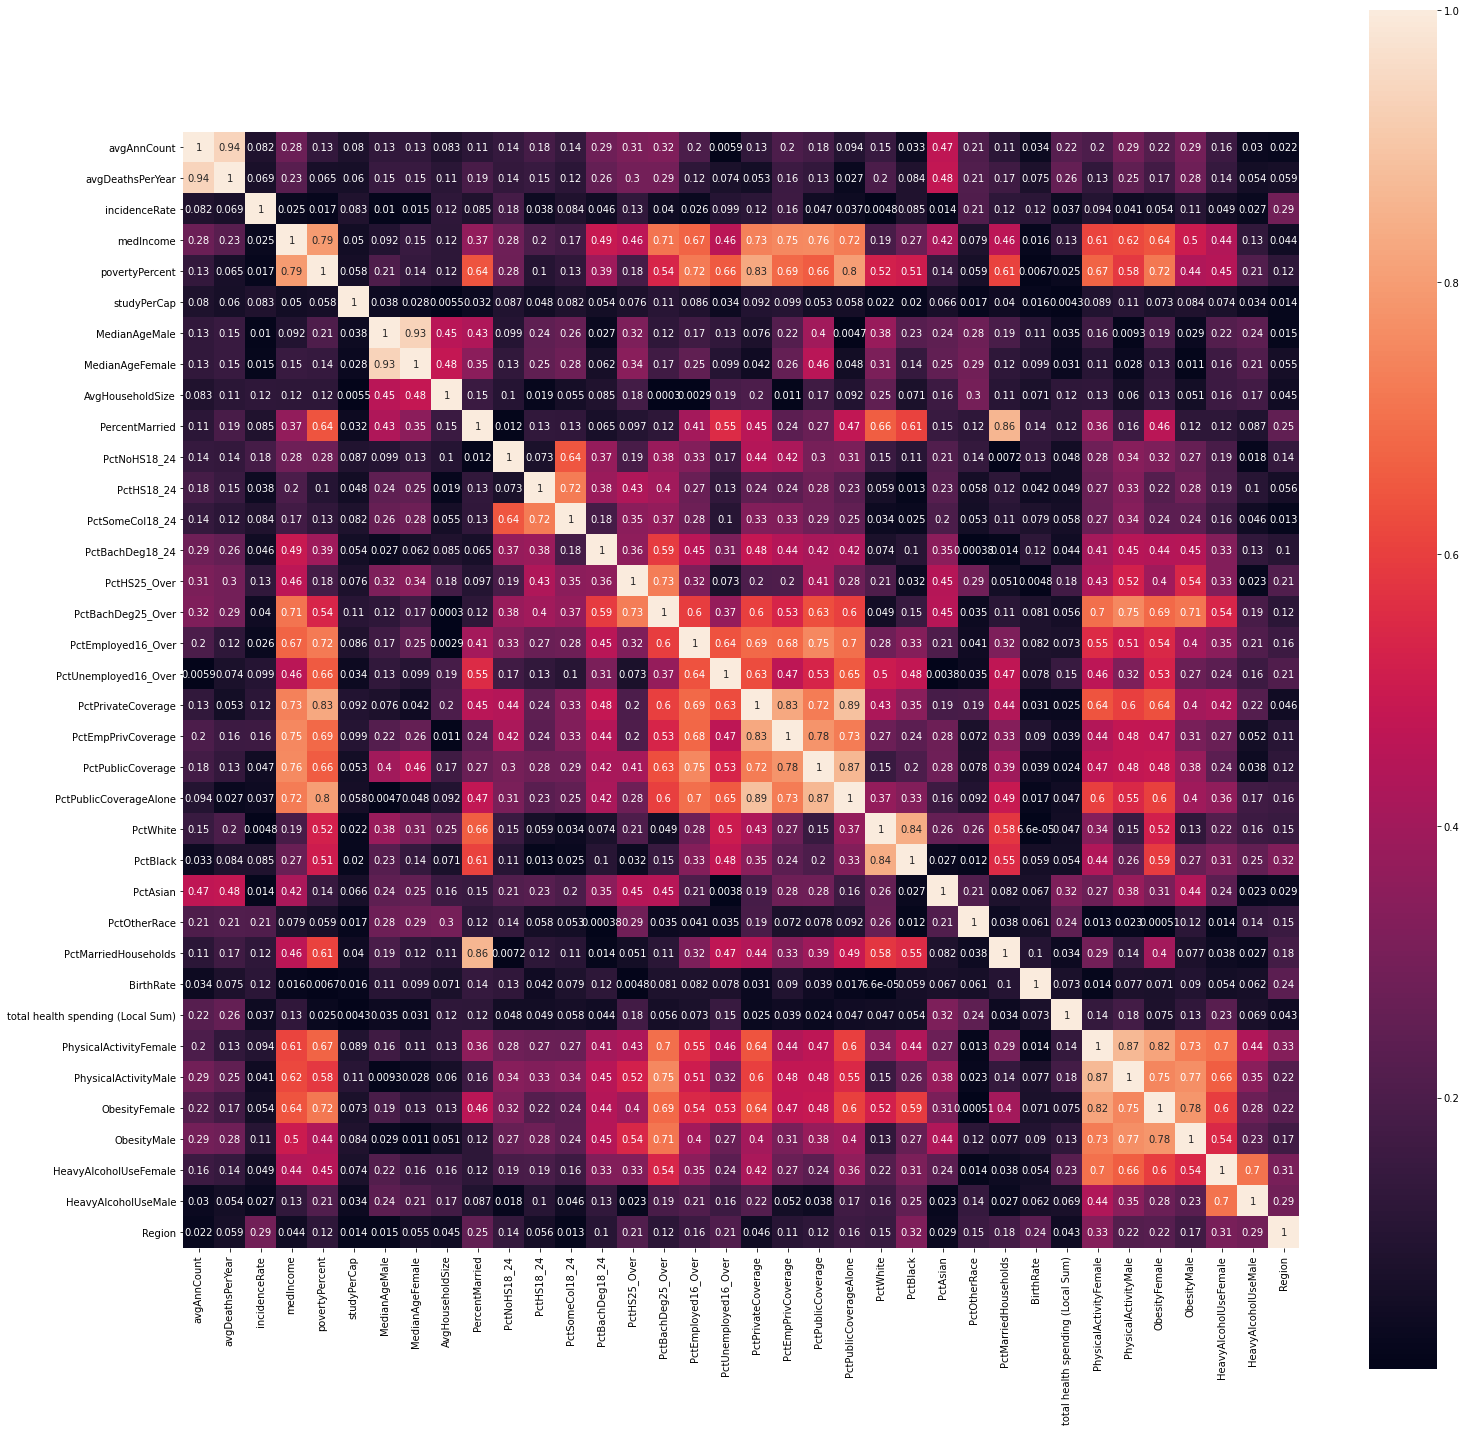

In [ ]:
### Looking at correlations of remaining 
numeric_columns = df.select_dtypes(include="number").columns.drop('DeathRate')
df_corr = df[numeric_columns].corr().abs()

# Making a heatmap
plt.figure(figsize=(25,25))
sns.heatmap(df_corr, annot=True, square=True)

In [ ]:
# Check for features with high correlation values

# Get only upper triangle of heatmap
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))

# Loop for only columns that have a high correlation (r >=0.75) in the UPPER HALF of the heatmap
high_corr = [column for column in upper.columns if any(upper[column] > 0.75)]
high_corr

['avgDeathsPerYear',
 'povertyPercent',
 'MedianAgeFemale',
 'PctPrivateCoverage',
 'PctEmpPrivCoverage',
 'PctPublicCoverage',
 'PctPublicCoverageAlone',
 'PctBlack',
 'PctMarriedHouseholds',
 'PhysicalActivityMale',
 'ObesityFemale',
 'ObesityMale']

Curiously, physical activity and obesity measures are correlated, which tracks, but alcohol use between genders isn't correlated to a high enough degree to be cut off at the 0.75 level.  For now, we'll keep both in.

In [ ]:
# Dropping highly correlated features
df.drop(high_corr, axis=1, inplace=True)
df.head()

avgAnnCount  DeathRate  ...  HeavyAlcoholUseMale  Region
0       1397.0      164.9  ...                  9.1    10.0
1        173.0      161.3  ...                 11.6    10.0
2        102.0      174.7  ...                 11.2    10.0
3        427.0      194.8  ...                  9.9    10.0
4         57.0      144.4  ...                 13.5    10.0

[5 rows x 27 columns]

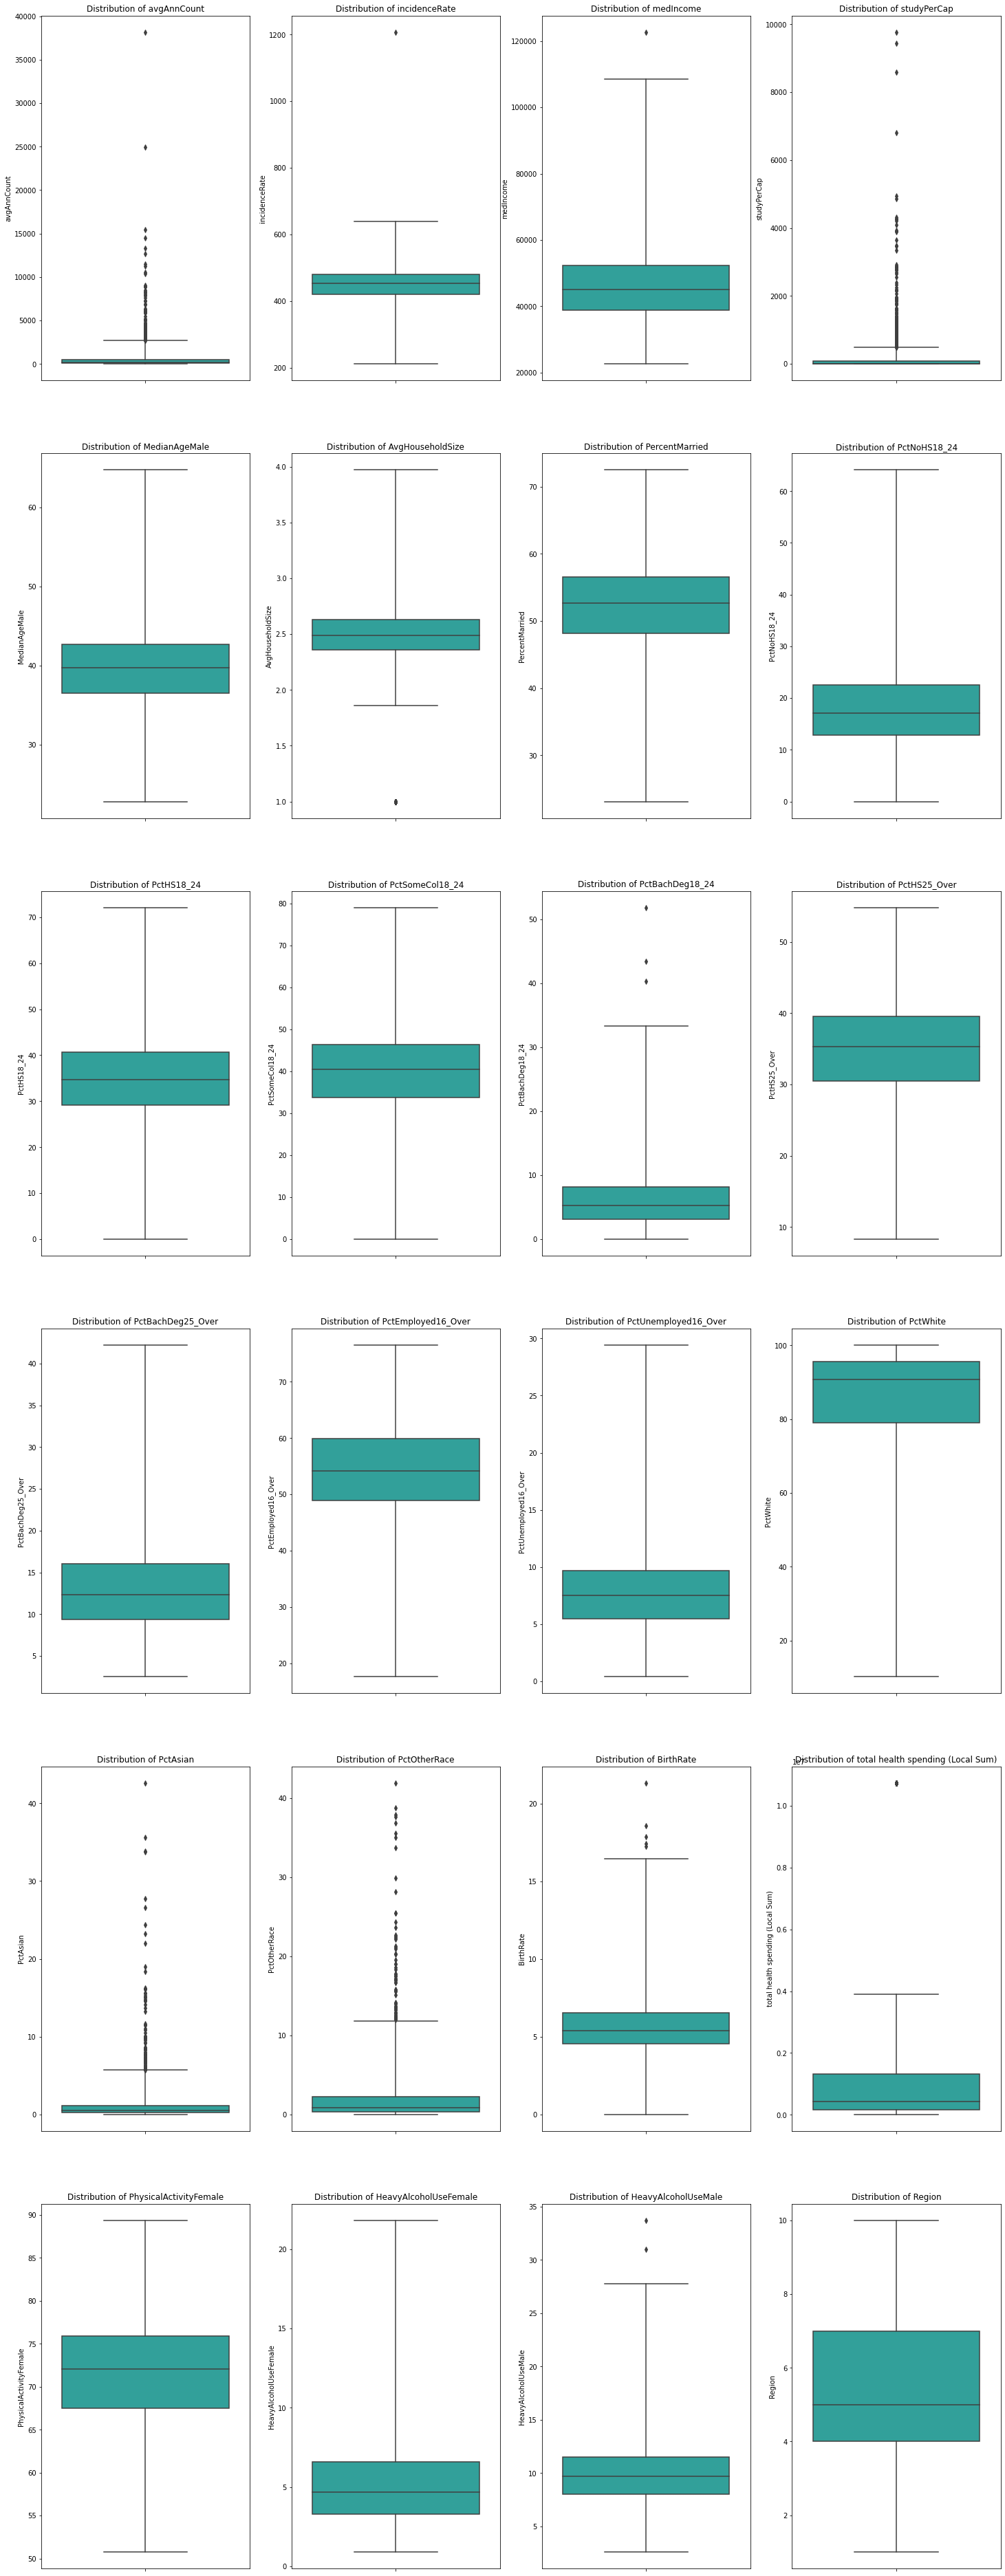

In [ ]:
#Plotting all numeric features
plt.figure(figsize=(25,80))

numeric_columns = df.select_dtypes(include="number").columns.drop("DeathRate")
i = 1
for feature in numeric_columns:
  plt.subplot(7,4,i)
  sns.boxplot(y=df[feature], whis=5, color="lightseagreen",  orient="v", )
  plt.title("Distribution of {}".format(feature))
  i+=1
plt.show();

The only features that appear to still have outliers of note are 

*avgAnnCount, studyperCap, and BirthRate which won't be included in the model as it would obviously be correlated to DeathRate (I was maintaining it in case there would be a relevant interaction term)

*features involving race, which for the audience of this project shouldn't be relevant, so we can ignore.

In [ ]:
df.drop(["PctWhite", "PctAsian", "PctOtherRace"], axis=1, inplace=True)

# Data Exploration

In [ ]:
# Moving DeathRate to front of df to better designate as target

# First getting all column names
df.columns.drop("DeathRate")

Index(['avgAnnCount', 'incidenceRate', 'medIncome', 'studyPerCap',
       'MedianAgeMale', 'Geography', 'AvgHouseholdSize', 'PercentMarried',
       'PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24', 'PctBachDeg18_24',
       'PctHS25_Over', 'PctBachDeg25_Over', 'PctEmployed16_Over',
       'PctUnemployed16_Over', 'BirthRate', 'State',
       'total health spending (Local Sum)', 'PhysicalActivityFemale',
       'HeavyAlcoholUseFemale', 'HeavyAlcoholUseMale', 'Region'],
      dtype='object')

In [ ]:
# Copying over
df = df[['DeathRate','avgAnnCount', 'incidenceRate', 'medIncome', 'studyPerCap',
       'MedianAgeMale', 'Geography', 'AvgHouseholdSize', 'PercentMarried',
       'PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24', 'PctBachDeg18_24',
       'PctHS25_Over', 'PctBachDeg25_Over', 'PctEmployed16_Over',
       'PctUnemployed16_Over', 'BirthRate', 'State',
       'total health spending (Local Sum)', 'PhysicalActivityFemale',
       'HeavyAlcoholUseFemale', 'HeavyAlcoholUseMale', 'Region']]

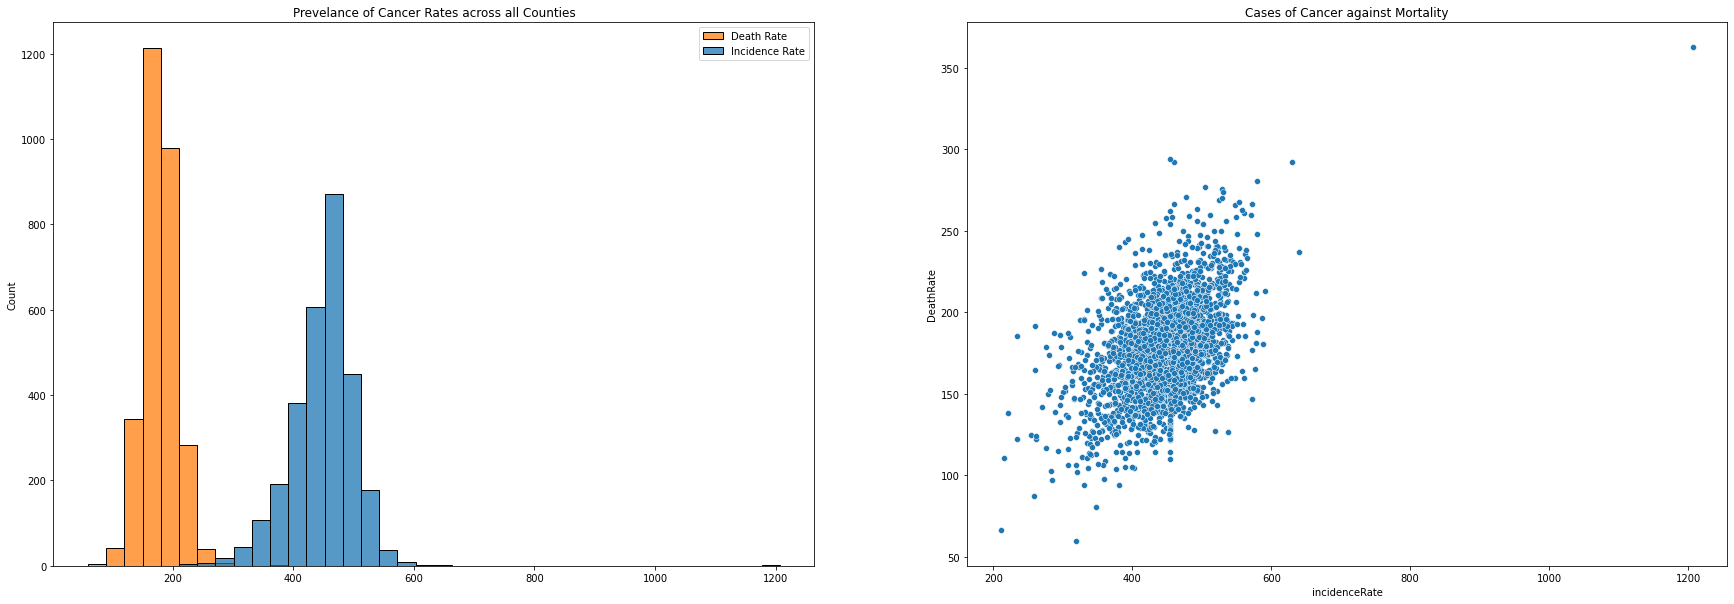

In [ ]:
# Looking at distribution of each 
plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
h = sns.histplot(data=df[["incidenceRate", "DeathRate"]], color="seagreen")
h.legend(["Death Rate","Incidence Rate"])
h.set_title("Prevelance of Cancer Rates across all Counties");

plt.subplot(1,2,2)
s = sns.scatterplot(data=df,x="incidenceRate", y="DeathRate")
s.set_title("Cases of Cancer against Mortality");

Text(0.5, 1.0, 'Cases of Cancer against Mortality')

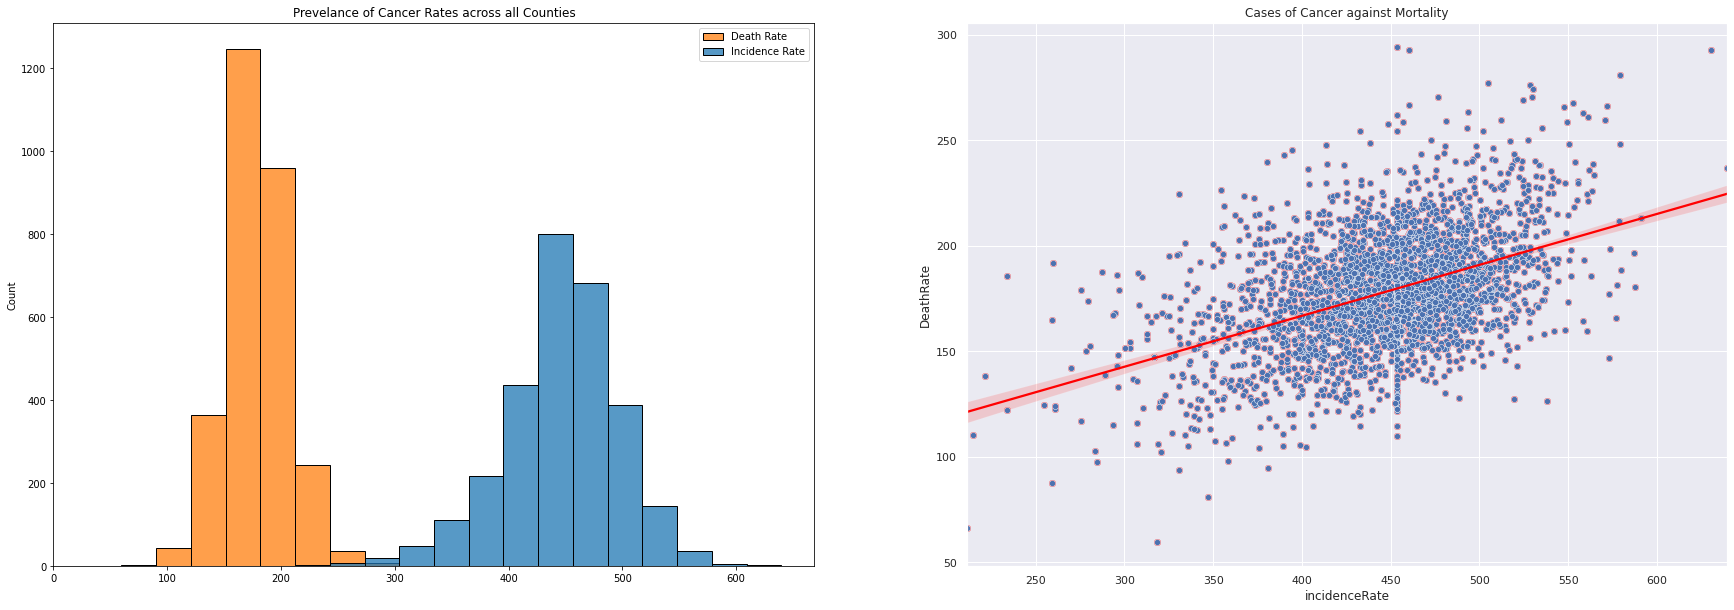

In [ ]:
# Seeing a large outlier
df[df["incidenceRate"] >= 7000]

# Dropping county; this is a very evident outlier that can hopefully still use this data depending on geographic divisions down the line
df.drop([2022],inplace=True)

plt.figure(figsize=(30,10))

plt.subplot(1,2,1)
h = sns.histplot(data=df[["incidenceRate", "DeathRate"]], color=["seagreen", "orange"])
h.set_xticks(ticks= range(0,700,100))
h.legend(["Death Rate","Incidence Rate"])
h.set_title("Prevelance of Cancer Rates across all Counties")
sns.set(style="darkgrid");

plt.subplot(1,2,2)
s = sns.regplot(data=df, x="incidenceRate", y="DeathRate", color="red")
sns.scatterplot(data=df,x="incidenceRate", y="DeathRate")
s.set_title("Cases of Cancer against Mortality")


Both have normal distributions with the incidence rate having a larger variance than death rate, which looks to have the most values around 150 (per 100,000), and it's slightly right skewed.  There are enough counties across a range of incidence rates that are able to share the same mortality rate; in other words, there's a somewhat notable portion of counties that have higher incidence rates but are able to limit their death rate.

There's an obvious correlation between incidence and death rates.  I'm going to test across different features to see what specific relationships might be shown.

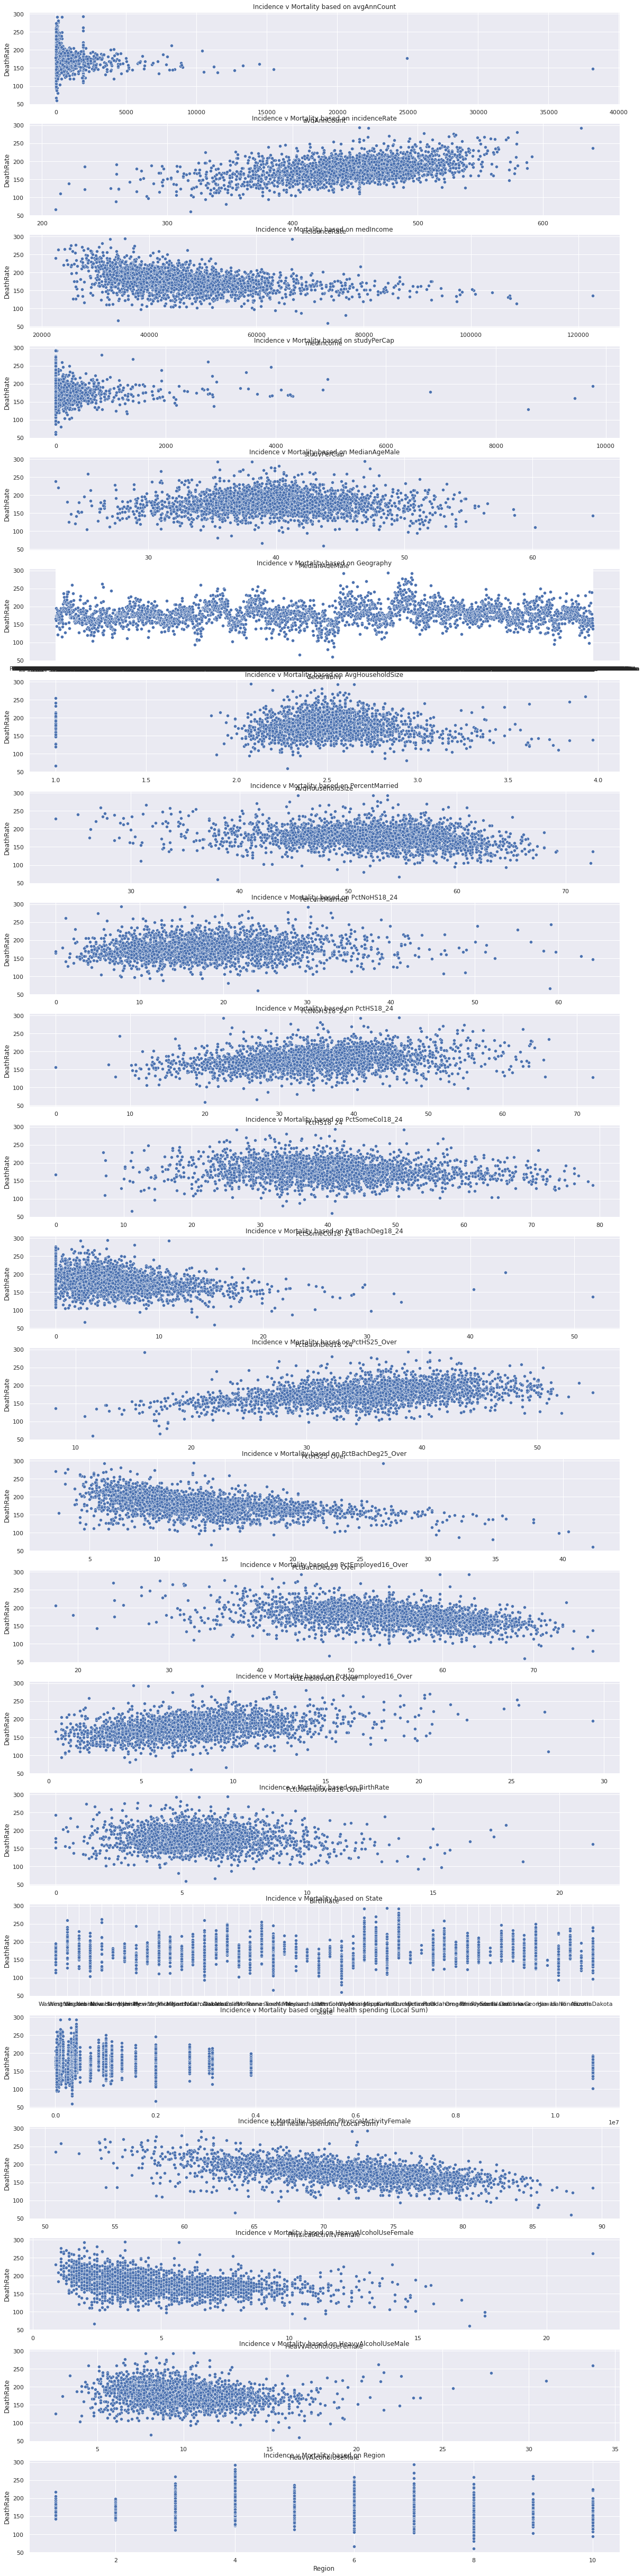

In [ ]:
plt.figure(figsize=(20,100))
i = 1
for feature in df.columns.drop("DeathRate"):
  plt.subplot(26,1,i)
  s = sns.scatterplot(data=df,x=feature, y="DeathRate")
  s.set_title("Incidence v Mortality based on {}".format(feature))
  i += 1

Some insights:
*   **Higher employement**, **more physical activity**, and **higher median incomes** all have slightly lower mortality rates relative to incidence rates

*   **Higher rates of not finishing high school** see higher DeathRates relative to incidences




<Figure size 2160x720 with 0 Axes>

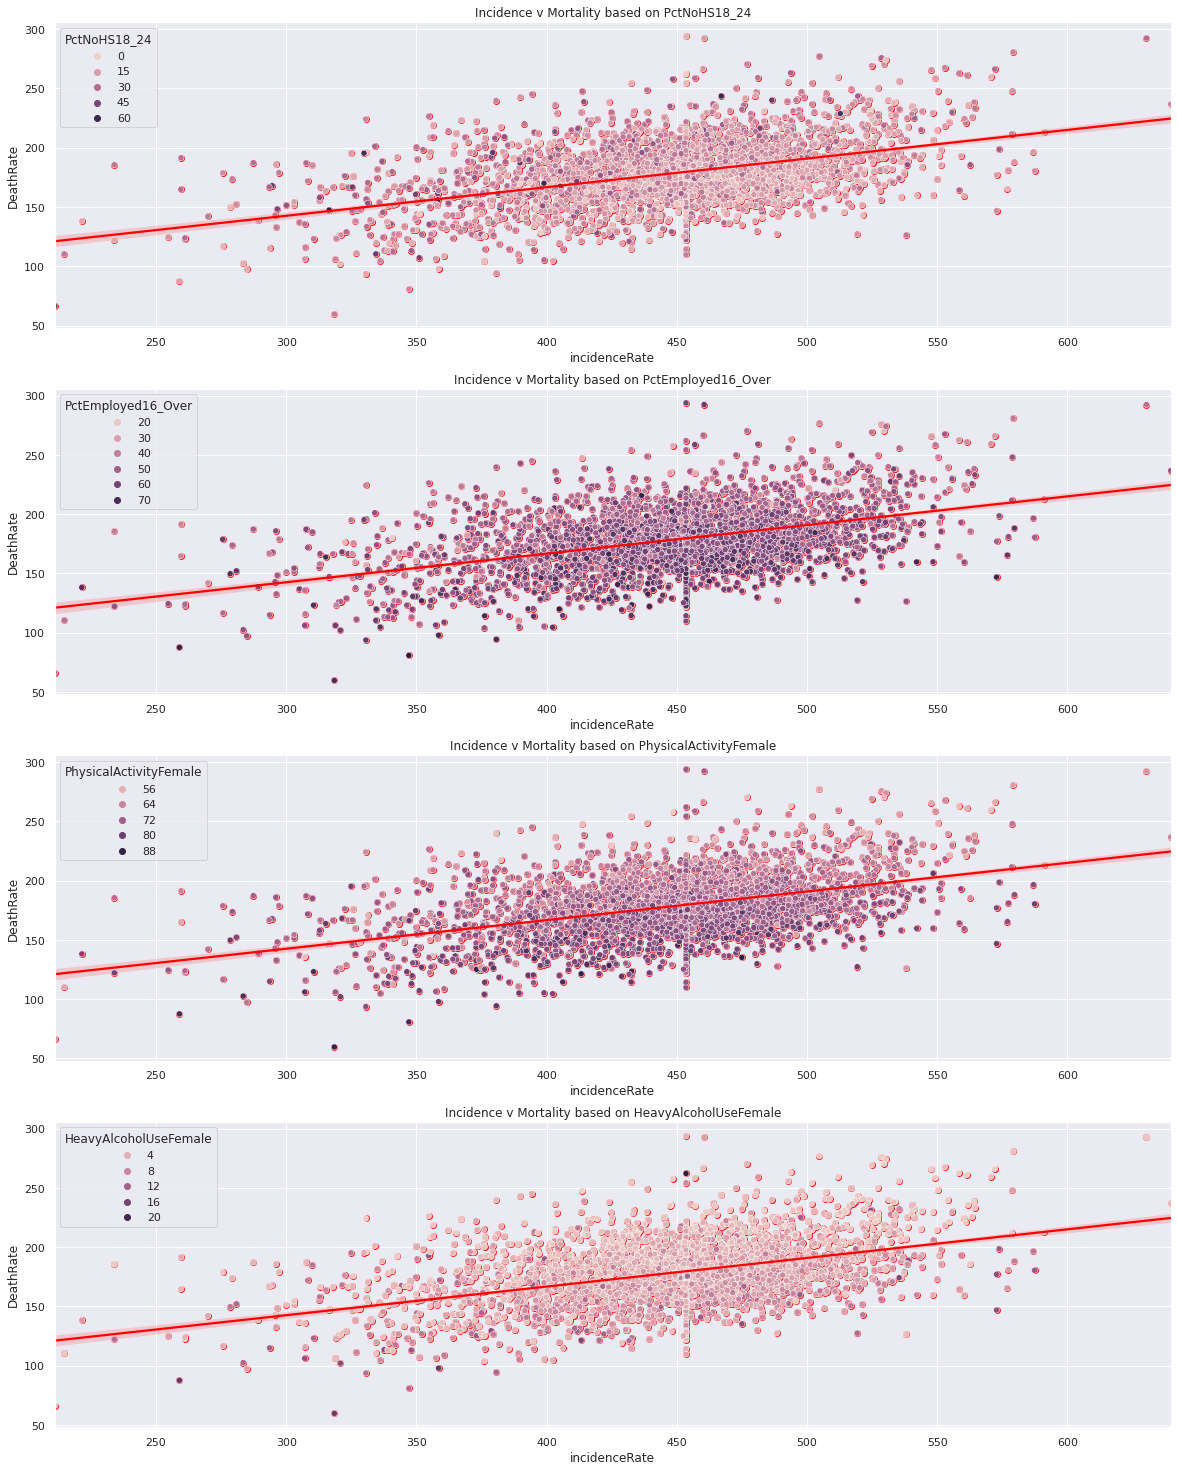

In [ ]:
# Taking a closer look
plt.figure(figsize=(30,10))

testing_columns = ["PctNoHS18_24", "PctEmployed16_Over", "PhysicalActivityFemale", "HeavyAlcoholUseFemale"]

plt.figure(figsize=(20,100))
i = 1
for feature in testing_columns:
  plt.subplot(15,1,i)
  s = sns.regplot(data=df, x="incidenceRate", y="DeathRate", color="red")
  sns.scatterplot(data=df,x="incidenceRate", y="DeathRate", hue=feature)
  s.set_title("Incidence v Mortality based on {}".format(feature))
  i += 1

These relationships with DeathRate seem to be present even after accounting for incidence rates.  For example, the higher prevelance in physical activity (dark hues) are towards the bottom across all incidence rates, indicating that physical health could benefit in decreasing mortality.

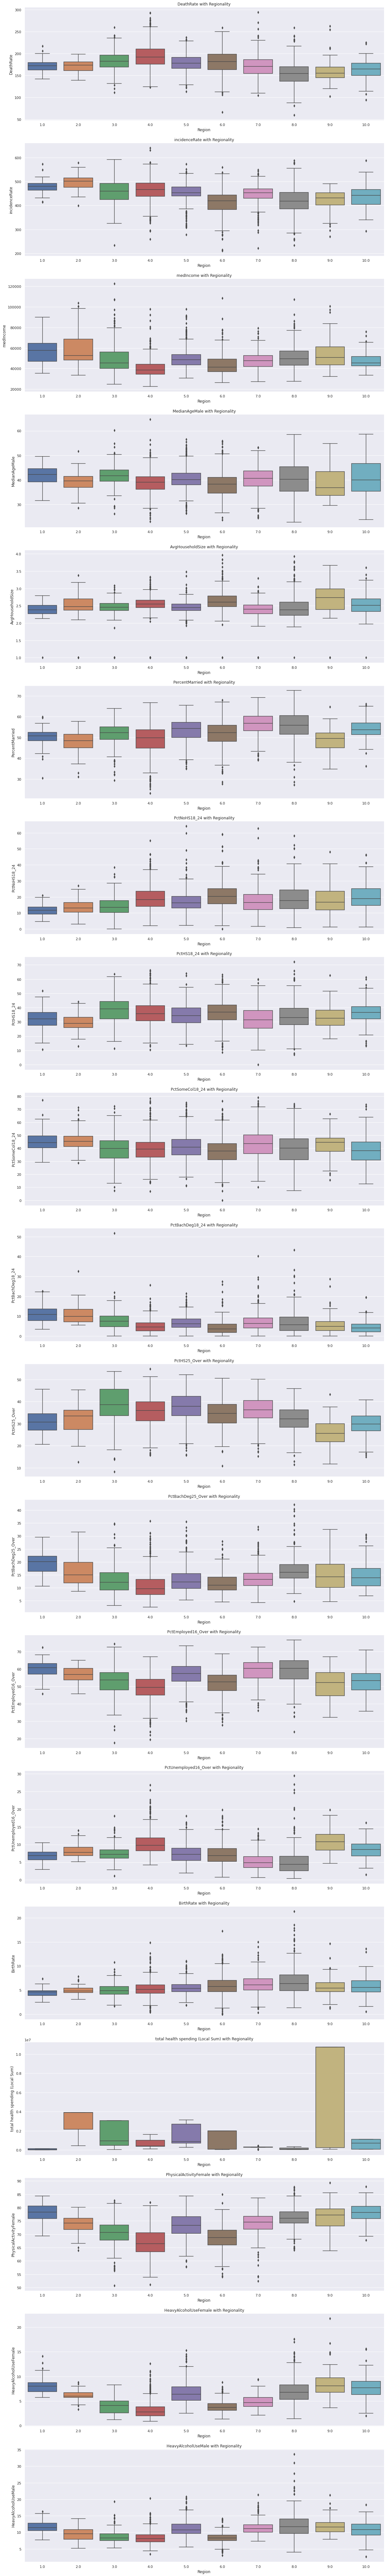

In [ ]:
# Testing against Region
numeric_columns = df.select_dtypes(include="number").columns

plt.figure(figsize=(20,200))
i = 1
for feature in numeric_columns.drop(["avgAnnCount", "studyPerCap", "Region"]):
  plt.subplot(26,1,i)
  s = sns.boxplot(data=df,x="Region", y=feature)
  s.set_title("{} with Regionality".format(feature))
  i += 1

Region 4 seems to most often have the "worst" distribution of any (lower physical activity, higher heavy drinking, etc.) but it is also the biggest so there's more room for variability.  It may be beneficial to break this region down further to see if these large variances are broken up any.

# Modeling
.......................................

# Dummy Regressor base comparison

Assessing most important features

In [ ]:
#Dropping features that don't add value
df.drop(["avgAnnCount", "incidenceRate"], axis=1, inplace=True)

In [ ]:
# Turn Region into dummy columns for tracking correlation
df = df.copy()

dummies = pd.get_dummies(df["Region"], prefix="Region ")
df = df.join(dummies)

In [ ]:
# Get correlations
deathrate_corr = df.corr().loc["medIncome":, "DeathRate"]
print("Correlations with DeathRate")
print("---------------------------")
np.abs(deathrate_corr).sort_values(ascending=False)

Correlations with DeathRate
---------------------------


PhysicalActivityFemale               0.568317
PctBachDeg25_Over                    0.485765
medIncome                            0.433233
PctHS25_Over                         0.406289
PctEmployed16_Over                   0.401819
HeavyAlcoholUseFemale                0.390467
PctUnemployed16_Over                 0.371977
Region _4.0                          0.310353
Region                               0.292954
PctBachDeg18_24                      0.285097
Region _8.0                          0.264994
PctHS18_24                           0.257818
PercentMarried                       0.246542
HeavyAlcoholUseMale                  0.197261
PctSomeCol18_24                      0.149279
Region _9.0                          0.122483
Region _10.0                         0.110563
total health spending (Local Sum)    0.107352
BirthRate                            0.098104
Region _7.0                          0.084098
PctNoHS18_24                         0.071856
AvgHouseholdSize                  

It seems only some dummy regions are even *weakly* correlated with DeathRate.  I'll still plan on including them all, for the sake of comparison between label encoded and dummy variable models, as Region itself is correlated about 0.29 with DeathRate.

Health spending doesn't seem to be correlated, I'm guessing the variable isn't specific enough to really apply towards a specific county.

MedianAge, HouseholdSize, and Birthrate also don't make the cut as their correlations are too low.

In [155]:
# Defining dependents and targets with regional dummies
Xd = df[["PhysicalActivityFemale", "PctBachDeg25_Over", "medIncome", "PctHS25_Over", "PctEmployed16_Over", "HeavyAlcoholUseFemale",
        "PctUnemployed16_Over", "Region _4.0", "PctBachDeg18_24", "Region _8.0", "PctHS18_24", "PercentMarried", "HeavyAlcoholUseMale",
         "PctSomeCol18_24", "Region _9.0", "Region _10.0", "Region _1.0", "Region _2.0", "Region _3.0", "Region _5.0",
         "Region _6.0", "Region _7.0"]]
yd = df["DeathRate"]

Xd_train,Xd_test,yd_train,yd_test = train_test_split(Xd, yd, test_size=0.2, random_state=25)

# Creating a dummy model
model_dum = DummyRegressor()

model_dum.fit(Xd_train,yd_train)
pred_dum = model_dum.predict(Xd_test)

In [156]:
# sklearn has no summary method, so setting up our own measurement characteristics
def performance(model, Xtest, ytest, pred):
  print("R-squared: ", model.score(Xtest,ytest))
  print("Adjusted R-squared", 1 - (1-model.score(Xtest, ytest))*(len(ytest)-1)/(len(ytest)-Xtest.shape[1]-1))
  print("------------")
  print('Mean Absolute Error: ', mean_absolute_error(ytest, pred))
  print('Mean Squared Error: ', mse(ytest, pred))
  print('Root MSE: ', rmse(ytest, pred))
  print('Mean Absolute Percentage Error', np.mean(np.abs((ytest - pred) / ytest)) * 100)

performance(model_dum, Xd_test, yd_test,pred_dum)

R-squared:  -0.00019095538209468185
Adjusted R-squared -0.039554463465111045
------------
Mean Absolute Error:  20.566529623115468
Mean Squared Error:  713.0126915448052
Root MSE:  26.702297495623952
Mean Absolute Percentage Error 12.028511012070094


It's worse than nothing!

# Models with One-hot encoded variables



OLS Regression

----

In [150]:
#Set up model
model_OLS = LinearRegression()

model_OLS.fit(Xd_train,yd_train)
pred_OLS = model_OLS.predict(Xd_test)

print(performance(model_OLS,Xd_test,yd_test,pred_OLS))

R-squared:  0.38656869693388163
Adjusted R-squared 0.362426498959902
------------
Mean Absolute Error:  15.400604287989495
Mean Squared Error:  437.3007995357445
Root MSE:  20.91173831932067
Mean Absolute Percentage Error 9.141843338801966
None


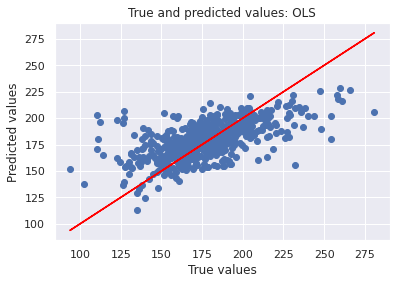

In [ ]:
#Visualize model
plt.scatter(yd_test, pred_OLS)
plt.plot(yd_test, yd_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: OLS")
plt.show()

This model isn't a very strong predictor of variance; many variables were not normally distributed, which may be leading to features with additional error.

The rest of the assumptions for OLS need to be tested upon before moving forward with this model.  What we haven't secured so far:
*   Error term normally distributed (the mean error must also be 0 but a constant term will account for that)
*   No collinearity in error terms, or between features and errors
*   Homoscedasticity

Text(0.5, 1.0, 'Error terms')

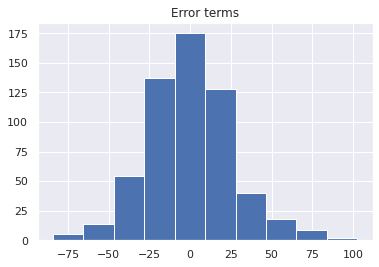

In [ ]:
# Error term distribution
errors = yd_test - pred

plt.hist(errors)
plt.title("Error terms")

The error is normal with center ~0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


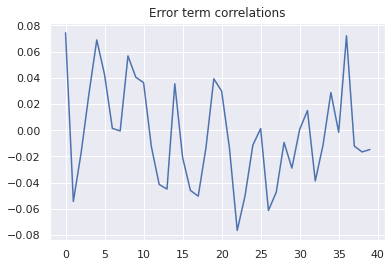

In [ ]:
# Checking for collinearity between error terms
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.title("Error term correlations")
plt.show()

Error terms have no patter of correlation

In [ ]:
# Checking for collinearity between errors and features 

Xd_train = sm.add_constant(Xd_train)

results = sm.OLS(yd_train, Xd_train).fit()

results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DeathRate   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.412
Method:                 Least Squares   F-statistic:                     78.50
Date:                Sat, 30 Jan 2021   Prob (F-statistic):          2.59e-251
Time:                        19:49:45   Log-Likelihood:                -10393.
No. Observations:                2327   AIC:                         2.083e+04
Df Residuals:                    2305   BIC:                         2.096e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    233.5436     11.491     20.324      0.000     211.009     256.078
PhysicalActivityFemale    -1.8271      0.149    -12.301      0.000      -2.118      -1.536
PctBachDeg25_Over          0.1226      0.200      0.614      0.539      -0.269       0.514
medIncome              -9.107e-05   7.01e-05     -1.299      0.194      -0.000    4.64e-05
PctHS25_Over               0.6411      0.116      5.518      0.000       0.413       0.869
PctEmployed16_Over        -0.0949      0.095     -0.998      0.318      -0.281       0.092
HeavyAlcoholUseFemale     -0.3599      0.375     -0.960      0.337      -1.095       0.376
PctUnemployed16_Over       0.8336      0.202      4.131      0.000       0.438       1.229
Region _4.0               26.4846      1.498     17.680      0.000      23.547      29.422
PctBachDeg18_24            0.1092      0.137      0.799      0.424      -0.159       0.377
Region _8.0               14.7776      1.964      7.523      0.000      10.925      18.630
PctHS18_24                 0.5269      0.082      6.405      0.000       0.366       0.688
PercentMarried            -0.1047      0.095     -1.100      0.271      -0.291       0.082
HeavyAlcoholUseMale        0.4625      0.259      1.787      0.074      -0.045       0.970
PctSomeCol18_24            0.3474      0.066      5.300      0.000       0.219       0.476
Region _9.0               14.5190      2.884      5.034      0.000       8.863      20.175
Region _10.0              23.9120      2.608      9.170      0.000      18.798      29.026
Region _1.0               32.3915      3.181     10.182      0.000      26.153      38.630
Region _2.0               24.5788      2.913      8.436      0.000      18.866      30.292
Region _3.0               23.6202      2.117     11.158      0.000      19.469      27.771
Region _5.0               27.2367      1.765     15.434      0.000      23.776      30.697
Region _6.0               21.5306      1.441     14.937      0.000      18.704      24.357
Region _7.0               24.4925      1.986     12.332      0.000      20.598      28.387
==============================================================================
Omnibus:                      125.129   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              482.606
Skew:                           0.003   Prob(JB):                    1.60e-105
Kurtosis:                       5.231   Cond. No.                     8.58e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.41e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is s

The features that have signficance that are *positive* are  **Pct_HS for both age groups, Pct_Unemployed16_Over, all regions, PctBachDeg18_24**, and **PctHS18_24**

The features that have significance that are *negative* are **PhysicalActivityFemale, PercentMarried**, and **PctOtherRace**

Physical activity, unemployement, and percent of high school graduates were also all factors that had different incident vs death rates discovered during data exploration.

.


Every other feature isn't uncorrelated with their error strongly enough to be considered signficiant.  There are no doubt many other factors missing here so to have so few features in this dataset be insignificant is unfortunately unsurprising.

In [ ]:
# Homoscedasticity
print(bartlett(pred, errors))
print(levene(pred,errors))

BartlettResult(statistic=39222.243078446874, pvalue=0.0)
LeveneResult(statistic=843.8672778654419, pvalue=6.366946393752283e-140)


K Nearest Neighbors

---

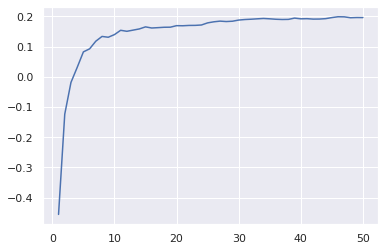

In [ ]:
# See what values of k work best
Xd_train,Xd_test,yd_train,yd_test = train_test_split(Xd,yd,test_size=0.2,random_state=25)

scores = []
for k in range(1,51):
  model_knn = KNeighborsRegressor(n_neighbors=k)
  model_knn.fit(Xd_train,yd_train)
  scores.append(model_knn.score(Xd_test,yd_test))

plt.plot(range(1,51),scores)

In [ ]:
# It looks like values of k somewhere between 30 and 50 work best
for neighbors in range(30,51):
  model_knn = KNeighborsRegressor(n_neighbors=neighbors)
  model_knn.fit(Xd_train,yd_train)
  pred_knn = model_knn.predict(Xd_test)
  print("number of neighbors:",neighbors)
  print(performance(model_knn, Xd_test,yd_test,pred_knn))
  print("*******************")
  print("*******************")

number of neighbors: 30
R-squared:  0.1879413446624323
Adjusted R-squared 0.15598197003376235
------------
Mean Absolute Error:  18.06189003436426
Mean Squared Error:  578.8975839251623
Root MSE:  24.060290603506065
Mean Absolute Percentage Error 10.713377284725066
None
*******************
*******************
number of neighbors: 31
R-squared:  0.18974011351757625
Adjusted R-squared 0.15785153122309803
------------
Mean Absolute Error:  18.05012748032369
Mean Squared Error:  577.6152837644063
Root MSE:  24.033628185615385
Mean Absolute Percentage Error 10.705702192386692
None
*******************
*******************
number of neighbors: 32
R-squared:  0.1907602523944234
Adjusted R-squared 0.15891181867828263
------------
Mean Absolute Error:  18.013842353951894
Mean Squared Error:  576.88805066715
Root MSE:  24.018493930035454
Mean Absolute Percentage Error 10.685909842643515
None
*******************
*******************
number of neighbors: 33
R-squared:  0.19205415136425874
Adjusted R-

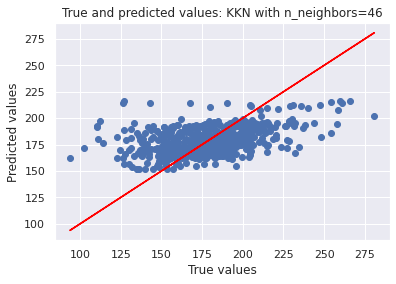

In [ ]:
# These are all very poor; let's get a visualization of the best of the bunch
model_knn = KNeighborsRegressor(n_neighbors=46)
model_knn.fit(Xd_train,yd_train)
pred_knn = model_knn.predict(Xd_test)

plt.scatter(yd_test, pred_knn)
plt.plot(yd_test, yd_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: KKN with n_neighbors=46")
plt.show()

KKN doesn't seem like a good option.

# Models with Label encoded variables



In [ ]:
# Label encoding
encoder = LabelEncoder()
encoder.fit(df["Region"])
df["Region"] = encoder.transform(df["Region"])

In [ ]:
# Defining dependents and targets with label encoded regions
Xe = df[["PhysicalActivityFemale", "PctBachDeg25_Over", "medIncome", "PctHS25_Over", "PctEmployed16_Over", "HeavyAlcoholUseFemale",
        "PctUnemployed16_Over", "Region", "PctBachDeg18_24", "PctHS18_24", "PercentMarried", "HeavyAlcoholUseMale","PctSomeCol18_24"]]
ye = df["DeathRate"]

Xe_train,Xe_test,ye_train,ye_test = train_test_split(Xe,ye,test_size=0.2, random_state=25)

Random Forest

---

In [177]:
#Setting up model
model_RF = RandomForestRegressor() #No random_state to allow for bagging
model_RF.fit(Xe_train,ye_train)
pred_RF = model_RF.predict(Xe_test)

performance(model_RF,Xe_test,ye_test,pred_RF)

R-squared:  0.40054771666971273
Adjusted R-squared 0.3868278580723645
------------
Mean Absolute Error:  14.917573883161513
Mean Squared Error:  427.33548397938137
Root MSE:  20.672094329781427
Mean Absolute Percentage Error 8.882179075853628


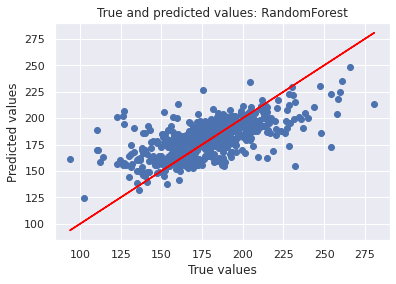

In [ ]:
plt.scatter(ye_test, pred_RF)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: RandomForest")
plt.show()

This model is a little stronger, and has lower error metrics, compared to OLS

Support Vector Matrices

---

R-squared:  0.18450314485157362
Adjusted R-squared 0.16583860415275398
------------
Mean Absolute Error:  18.174730838897162
Mean Squared Error:  581.3485959924257
Root MSE:  24.111171601405555
Mean Absolute Percentage Error 10.813789120799104
None


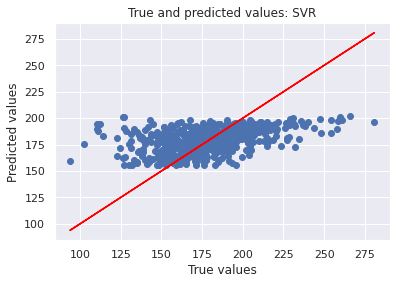

In [127]:
# Set up model
model_svm = SVR()
model_svm.fit(Xe_train,ye_train)
pred_svm = model_svm.predict(Xe_test)

print(performance(model_svm,Xe_test,ye_test,pred_svm))

plt.scatter(ye_test, pred_svm)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: SVR")
plt.show()

SVR also doesn't seem like a good option

Gradient Boosting with Decision Trees

---

In [191]:
#Set up model
model_gb = GradientBoostingRegressor() #No random_state again
model_gb.fit(Xe_train,ye_train)
pred_gb = model_gb.predict(Xe_test)

performance(model_gb,Xe_test, ye_test,pred_gb)

R-squared:  0.412626601091577
Adjusted R-squared 0.39918319583487005
------------
Mean Absolute Error:  14.867978648289645
Mean Squared Error:  418.72473035663745
Root MSE:  20.462764484708252
Mean Absolute Percentage Error 8.767087181053057


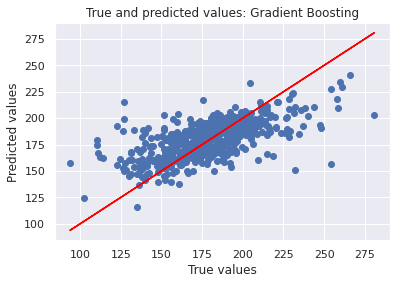

In [ ]:
plt.scatter(ye_test, pred_gb)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: Gradient Boosting")
plt.show()

With several runs through, gradient boosting looks close enough to RandomForest and OLS that I'm going to try to tune all three

# Tuning Highest Performing Models

OLS regression

---

In [ ]:
####LIKELY DON"T NEED TO DO THIS SINCE THERE AREN"T VERY MANY FEATURES TO BEGIN WITH
####


# I'll try tuning using all regularization models

#I'll first get the best alpha value for the regularization term
alphas = [10**e for e in [10,20,30,40,50]]

model_ridge = RidgeCV(alphas=alphas, cv=5)
model_lasso = LassoCV(alphas=alphas, cv=5, random_state=25)
model_en = ElasticNetCV(alphas=alphas, cv=5)

#Use model with dummy variables from before
alpha_ridge = model_ridge.fit(Xd_train,yd_train)
print("Alpha for Ridge: {}".format(alpha_ridge.alpha_))

alpha_lasso = model_lasso.fit(Xd_train,yd_train)
print("Alpha for Lasso: {}".format(alpha_lasso.alpha_))

alpha_en = model_en.fit(Xd_train,yd_train)
print("Alpha for Elastic Net: {}".format(alpha_en.alpha_))

Alpha for Ridge: 10000000000
Alpha for Lasso: 100000000000000000000000000000000000000000000000000
Alpha for Elastic Net: 100000000000000000000000000000000000000000000000000


R-squared:  0.3916601989903944
Adjusted R-squared 0.36771838213491803
------------
Mean Absolute Error:  20.566529623115468
Mean Squared Error:  713.0126915448052
Root MSE:  26.702297495623952
Mean Absolute Percentage Error 12.028511012070094


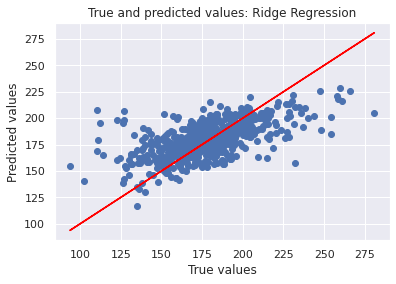

In [ ]:
# Ridge regression

model_ridge = Ridge(alpha=10*10, random_state=25)
model_ridge.fit(Xd_train,yd_train)
pred_ridge = model_ridge.predict(Xd_test)

performance(model_ridge,Xd_test,yd_test,pred_ridge)

plt.scatter(ye_test, pred_ridge)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: Ridge Regression")
plt.show()

This is the one of the worst models so far!  This is likely due to the small number of features used on the dataset; since we don't really need to limit the effect of any features and they all add hold at least ~0.10 correlation with DeathRate, Ridge and other additional cost function additions.  I'll run Lasso and ElasticNet just to see how these three compare.

R-squared:  -0.00019095538209468185
Adjusted R-squared -0.039554463465111045
------------
Mean Absolute Error:  20.566529623115468
Mean Squared Error:  713.0126915448052
Root MSE:  26.702297495623952
Mean Absolute Percentage Error 12.028511012070094


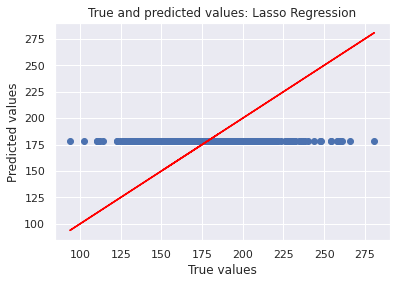

In [ ]:
# Lasso regression

model_lasso = Lasso(alpha=10**50, random_state=25)
model_lasso.fit(Xd_train,yd_train)
pred_lasso = model_lasso.predict(Xd_test)

performance(model_lasso,Xd_test,yd_test,pred_lasso)

plt.scatter(ye_test, pred)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: Lasso Regression")
plt.show()

The worst model out of all of them!  This makes sense; as stated before, we don't need to limit coefficients of features when we have so few.

R-squared:  -0.00019095538209468185
Adjusted R-squared -0.039554463465111045
------------
Mean Absolute Error:  20.566529623115468
Mean Squared Error:  713.0126915448052
Root MSE:  26.702297495623952
Mean Absolute Percentage Error 12.028511012070094


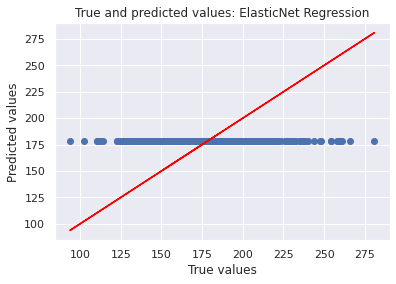

In [ ]:
# ElasticNet regression

model_EN = ElasticNet(alpha=10**50, random_state=25)
model_EN.fit(Xd_train,yd_train)
pred_EN = model_en.predict(Xd_test)

performance(model_en,Xd_test,yd_test,pred_EN)

plt.scatter(ye_test, pred_EN)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: ElasticNet Regression")
plt.show()

Also worse than nothing.  The Linear Regression by itself is better than adding to the cost function to limit variation.

RandomForest

---

In [178]:
#Using GridSearch to find best set of parameters

parameters = {"n_estimators":[10,20,50,100,1000],
              "max_depth":[None,1,2,5,10,15,20]} # Will use default mse criterion

model_tune_RF = GridSearchCV(model_RF, parameters, cv=5)

model_tune_RF.fit(Xe_train,ye_train)
pred_tune_RF = tune_model_RF.predict(Xe_test)

R-squared:  0.41103149077478074
Adjusted R-squared 0.3975515777115275
------------
Mean Absolute Error:  14.77132583799367
Mean Squared Error:  419.86184711836154
Root MSE:  20.490530669515653
Mean Absolute Percentage Error 8.785305996280893
None



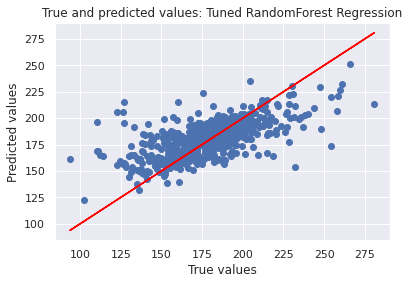

Best paramters:{'max_depth': 10, 'n_estimators': 1000}


In [ ]:
print(performance(tune_model_RF,Xe_test,ye_test,pred_tune_RF))
print()

plt.scatter(ye_test, pred_tune_RF)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: Tuned RandomForest Regression")
plt.show()

print("Best paramters:{}".format(model_tune_RF.best_params_))

There was only a slight improvement over the initial RandomForest model in terms of capturing variance, due to setting max_depth to 10.  It seems like the number of estimators increasing also led to better performance, but due to the decreasing returns of increasing n, especially with how little it improved to this stage, I'm going to leave this as the best model.

Gradient Boosting

---

In [182]:
#Using GridSearch to find best set of parameters

parameters = {"n_estimators":[10,50,100,500, 1000],
              "max_depth":[None,1,2,5,10,15,20],
              "learning_rate": [0.1,0.2,0.3,0.4,0.5]} # Will use default mse criterion

model_gb = GradientBoostingRegressor()
model_tune_gb = GridSearchCV(model_gb, parameters, cv=5)

model_tune_gb.fit(Xe_train,ye_train)
pred_tune_gb = model_tune_gb.predict(Xe_test)

R-squared:  0.39445984745036977
Adjusted R-squared 0.38060065381807184
------------
Mean Absolute Error:  14.952248707158574
Mean Squared Error:  431.6753832701105
Root MSE:  20.776799158438976
Mean Absolute Percentage Error 8.851591456337529
None



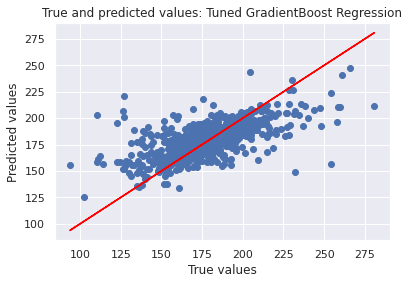

Best paramters:{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [183]:
print(performance(model_tune_gb,Xe_test,ye_test,pred_tune_gb))
print()

plt.scatter(ye_test, pred_tune_gb)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: Tuned GradientBoost Regression")
plt.show()

print("Best paramters:{}".format(model_tune_gb.best_params_))

This model seemed to do worse than the initial gradient boost regressor, which indicates that having a max depth of 3 (not included in the tuning parameter options) is more strongly tied to performance than others.  Let's see how setting a model to the best parameters with a max depth of 3 performs

In [184]:
# Using parameters set above
model_tune_gb1 = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=50)

model_tune_gb1.fit(Xe_train,ye_train)
pred_tune_gb1 = model_tune_gb1.predict(Xe_test)

R-squared:  0.41480137867240124
Adjusted R-squared 0.40140774825469205
------------
Mean Absolute Error:  14.880298740262786
Mean Squared Error:  417.17438238751157
Root MSE:  20.42484718149714
Mean Absolute Percentage Error 8.7784171037844
None



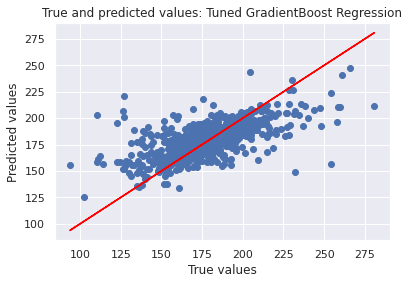

In [185]:
print(performance(model_tune_gb1,Xe_test,ye_test,pred_tune_gb1))
print()

plt.scatter(ye_test, pred_tune_gb)
plt.plot(ye_test, ye_test, color="red")
plt.xlabel("True values")
plt.ylabel("Predicted values")
plt.title("True and predicted values: Tuned GradientBoost Regression")
plt.show()

This model seems to be the best option yet!  I'll further tune the subsample parameter to see if we can increase accuracy while still delivering less variance than other models

In [186]:
# Subsampling with proportion 0.9

model_tune_gb2 = GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9)
model_tune_gb2.fit(Xe_train,ye_train)
pred_tune_gb2 = model_tune_gb2.predict(Xe_test)

performance(model_tune_gb2, Xe_test, ye_test, pred_tune_gb2)

R-squared:  0.4127382538416293
Adjusted R-squared 0.39929740401758207
------------
Mean Absolute Error:  14.942830579096466
Mean Squared Error:  418.64513572782704
Root MSE:  20.460819527277664
Mean Absolute Percentage Error 8.804249923222903


In [187]:
# Subsampling with proportion 0.8

model_tune_gb3 = GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8)
model_tune_gb3.fit(Xe_train,ye_train)
pred_tune_gb3 = model_tune_gb3.predict(Xe_test)

performance(model_tune_gb3, Xe_test, ye_test, pred_tune_gb3)

R-squared:  0.4226150299397917
Adjusted R-squared 0.4094002330898222
------------
Mean Absolute Error:  14.842513091516796
Mean Squared Error:  411.6042135202813
Root MSE:  20.288031287443374
Mean Absolute Percentage Error 8.767778389482402


In [188]:
# Subsampling with proportion 0.7

model_tune_gb4 = GradientBoostingRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.9)
model_tune_gb4.fit(Xe_train,ye_train)
pred_tune_gb4 = model_tune_gb4.predict(Xe_test)

performance(model_tune_gb4, Xe_test, ye_test, pred_tune_gb4)

R-squared:  0.4113879026245113
Adjusted R-squared 0.3979161468747202
------------
Mean Absolute Error:  14.882832930227094
Mean Squared Error:  419.6077694635824
Root MSE:  20.48432985146408
Mean Absolute Percentage Error 8.793899679231835


Setting `subsample=0.8` seems to produce the best R^2 values and lowest error metrics.  It has a slightly higher mape value, but as a whole seems to be more explanatorily powerful.  I would say this is my best model.

# Summary and next steps

In [216]:
#Making adj. R^2 function
def ar2(model):
  if model == model_OLS:
    ar2score = 1 - (1-model.score(Xd_test, yd_test))*(len(yd_test)-1)/(len(yd_test)-Xd_test.shape[1]-1)
  
  else:
    ar2score = 1 - (1-model.score(Xe_test, ye_test))*(len(ye_test)-1)/(len(ye_test)-Xe_test.shape[1]-1)

  return ar2score

#Making Mean absolute error percentage function
def mae(y,pred):
  mean_absolute_error = np.mean(np.abs((y - pred) / y)) * 100
  return mean_absolute_error

In [217]:
# Comparing best gradient boosting model to inital gb model and best performing OLS and RandomForest
models = {"Linear_Regression":[model_OLS, Xd_test, yd_test, pred_OLS], 
          "RandomForest":[model_RF, Xe_test, ye_test, pred_RF],
          "GradientBoosting":[model_gb, Xe_test, ye_test, pred_gb],
          "Tuned_RandomForest":[model_tune_RF, Xe_test, ye_test, pred_tune_RF],
          "Tuned_GradientBoosting":[model_tune_gb1, Xe_test, ye_test, pred_tune_gb1]}


for model in models.keys():
  print("Improvement of model_tune_gb3 over {}".format(model))
  print("------------------------------------")
  print("adj. R^2: {}".format(round( (ar2(model_tune_gb3) - ar2(models[model][0])) / ar2(models[model][0]) * 100, 2)) , '%')
  print("Mean Absolute Error: {}".format(round((mean_absolute_error(ye_test,pred_tune_gb3) - mean_absolute_error(models[model][2], models[model][3])) / mean_absolute_error(models[model][2], models[model][3]) * 100, 2)), '%')
  print("Mean Squared Error: {}".format(round((mse(ye_test,pred_tune_gb3) - mse(models[model][2], models[model][3])) / mse(models[model][2], models[model][3]) * 100, 2)), '%')
  print("Root MSE: {}".format(round((rmse(ye_test,pred_tune_gb3) - rmse(models[model][2], models[model][3])) / rmse(models[model][2], models[model][3]) * 100, 2)), '%')  
  print("Mean Abs. Error: {}".format(round((mae(ye_test,pred_tune_gb3) - mae(models[model][2], models[model][3])) / mae(models[model][2], models[model][3]) * 100, 2)), '%')    
  print()

Improvement of model_tune_gb3 over Linear_Regression
------------------------------------
adj. R^2: 12.96 %
Mean Absolute Error: -3.62 %
Mean Squared Error: -5.88 %
Root MSE: -2.98 %
Mean Abs. Error: -4.09 %

Improvement of model_tune_gb3 over RandomForest
------------------------------------
adj. R^2: 5.84 %
Mean Absolute Error: -0.5 %
Mean Squared Error: -3.68 %
Root MSE: -1.86 %
Mean Abs. Error: -1.29 %

Improvement of model_tune_gb3 over GradientBoosting
------------------------------------
adj. R^2: 2.56 %
Mean Absolute Error: -0.17 %
Mean Squared Error: -1.7 %
Root MSE: -0.85 %
Mean Abs. Error: 0.01 %

Improvement of model_tune_gb3 over Tuned_RandomForest
------------------------------------
adj. R^2: 3.48 %
Mean Absolute Error: 0.48 %
Mean Squared Error: -1.97 %
Root MSE: -0.99 %
Mean Abs. Error: -0.2 %

Improvement of model_tune_gb3 over Tuned_GradientBoosting
------------------------------------
adj. R^2: 1.99 %
Mean Absolute Error: -0.25 %
Mean Squared Error: -1.34 %
Root MSE

The best tuned gradient boosting model improves on all metrics over the other models, except having slightly more bias than the tuned RandomForest.

For the purposes of our audience, we only want to know effects of each feature vs its coefficient value, so we'll rank features.

In [249]:
Xe.columns

Index(['PhysicalActivityFemale', 'PctBachDeg25_Over', 'medIncome',
       'PctHS25_Over', 'PctEmployed16_Over', 'HeavyAlcoholUseFemale',
       'PctUnemployed16_Over', 'Region', 'PctBachDeg18_24', 'PctHS18_24',
       'PercentMarried', 'HeavyAlcoholUseMale', 'PctSomeCol18_24'],
      dtype='object')

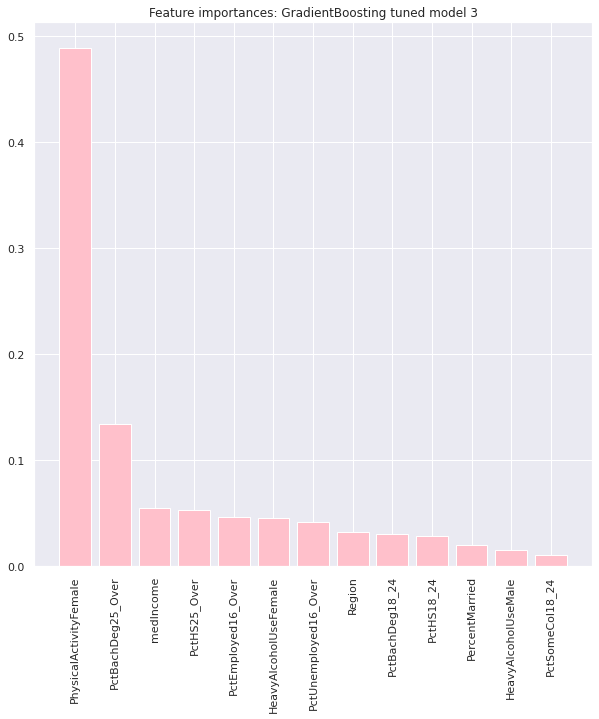

In [256]:
# Ranking features of GradientBoost model
feature_importances = model_tune_gb3.feature_importances_
sorted_features = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10,10))
plt.bar(range(Xe.shape[1]), feature_importances[sorted_features], color='pink')
plt.xticks(range(Xe.shape[1]), Xe.columns, rotation=90);
plt.title("Feature importances: GradientBoosting tuned model 3")
plt.show()

It appears **physical activity** (here listed as PhysicalActivityFemale but really account for both since the genders have high correlation) is the biggest influence on cancer death reates, followed by the **population over 25 having a bachelor's degree**, **median income**, and the **population over 25 finishing high school.** Geographic region seems to have little effect on death rate, by the division made here.

---

Through tuning a Grandient Boosting Regressor, we were able to get a model that predicts ~40% of the variance of a county's qualities and its associate DeathRate from cancer (as measured in every 100,000).  The increase in the initial gb model and the refined one is small, but does show that default parameters  can't be relied on to be the highest performing.


However, with this set of features, we're unable to create a very strong model.  I suspect this is due to multiple factors:


*   **Not containing enough influencing factors**: There are impacting factors that are not included in this dataset, such as city infastructure quality, air quality/general climate, number of accessible healthcare facilities, and other factors that could have a potential effect on deathrate.  We also weren't able to include specific county spending on public health, which I suspect would have some sort of correlation in being able to prevent more deaths.

*   **Unspecified target**: This model measures DeathRate from *any* cancer, and there are different causes that could contribute to higher prevelance of a certain type, ie smoking leads to greater chance of lung cancer.  Specifying the type of cancer that's perhaps the most prevelant in a state or region could create a stronger model.

*   **Division of geographic regions**: The geographic division is based on the regions defined by the HHS department, which does not necessarily translate to the best division in this model. The regions differences in this model themselves were not very strong explanatory factors EXCEPT for Region 4, which both contained the largest number of states and contained many southern states.  A better division of regions may be by culture, climate, wealth, or even by individual state (though proportional differences in the number of counties in each made me avoid that division here).  Further refinement of this model could include different regional divisions between counties; while this isn't necessarily controllable by the intended audience of this model (county governments), it would provide insight as to what extent their location impacts them (if any).

